In [1]:
import copy as c
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing

# Reading data

In [2]:
production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

# Procecing data

In [3]:
REGION = ['SWK', 'Sarawak', 'SWK']
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

In [4]:
production[(production['Region'] == REGION[0])].head()

index Region  Year  Month  Production  Diff_production
1422      0    SWK  1998      1      19.311           -8.946
1423      1    SWK  1998      2      19.734         -409.531
1424      2    SWK  1998      3      19.716            0.423
1425      3    SWK  1998      4      21.720           -0.018
1426      4    SWK  1998      5      23.252            2.004

In [5]:
rainfall[rainfall['Region'] == REGION[1]].head()

Region  Year  Month  Rainfall
246  Sarawak  1980      1  551.2875
247  Sarawak  1981      1  574.7125
248  Sarawak  1982      1  445.3250
249  Sarawak  1983      1  424.3000
250  Sarawak  1984      1  490.4500

In [6]:
area[area['Region'] == REGION[2]].head()

Area_New  Area_ma  Area_ma_new  Area_npa  Area_rpa Region  Year
215       0.0      0.0     0.000000       0.0       0.0    SWK  1974
216       8.0      7.0     7.000000      15.0       0.0    SWK  1975
217       8.0      9.0     9.000000      17.0       0.0    SWK  1976
218       7.0     12.0     4.615385      19.0       0.0    SWK  1977
219       9.0     13.0    -0.230769      22.0       0.0    SWK  1978

In [7]:
def process_data(production, rainfall, area, REGION, PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    data = production[production.Region == REGION[0]]
    data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                        rainfall[rainfall.Region == REGION[1]][['Year', 'Month', 'Rainfall']], 
                        on=['Year', 'Month'], how='left')

    data = pd.merge(data, area[area.Region == REGION[2]][
            ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')
            
    data['Year'] = data['Year'].astype(int)
    data['Month'] = data['Month'].astype(int)
    data.reset_index(inplace=True)

    data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                       inplace=True)

    data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
    data['Time'] = np.arange(len(data))
    for lag in RAINFALL_LAGS:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
        data['Rainfall_{0}'.format(lag)] = temp
       
    for lag in PRODUCTION_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
            data['Production_{0}'.format(lag)] = temp
        
    PRODUCTION = data.Production
    data.drop(['Production'], axis=1, inplace=True)

    data.fillna(data.mean(), inplace=True)

        #  And finally drop rainfalls
    data.drop(['Rainfall'], axis=1, inplace=True)
        ### HERE I CAN ADD FEATURE ENGINEERING!!!

        #  And clip first year
    for col in data.columns:
            data['_'.join([REGION[1], str(col)])] = data[col]
            data.drop([col], axis=1, inplace=True)
        
    output = (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])
    return output

In [8]:
DATA = process_data(production, rainfall, area, REGION, PRODUCTION_LAGS, RAINFALL_LAGS)

In [9]:
DATA

(            Sarawak_Month  Sarawak_Area_ma  Sarawak_Area_npa  \
 1999-01-01              1       228.000000        320.000000   
 1999-02-01              2       228.000000        320.000000   
 1999-03-01              3       228.000000        320.000000   
 1999-04-01              4       228.000000        320.000000   
 1999-05-01              5       228.000000        320.000000   
 1999-06-01              6       228.000000        320.000000   
 1999-07-01              7       228.000000        320.000000   
 1999-08-01              8       228.000000        320.000000   
 1999-09-01              9       228.000000        320.000000   
 1999-10-01             10       228.000000        320.000000   
 1999-11-01             11       228.000000        320.000000   
 1999-12-01             12       228.000000        320.000000   
 2000-01-01              1       241.000000        330.000000   
 2000-02-01              2       241.000000        330.000000   
 2000-03-01              

In [10]:
DATA[0]

Sarawak_Month  Sarawak_Area_ma  Sarawak_Area_npa  \
1999-01-01              1       228.000000        320.000000   
1999-02-01              2       228.000000        320.000000   
1999-03-01              3       228.000000        320.000000   
1999-04-01              4       228.000000        320.000000   
1999-05-01              5       228.000000        320.000000   
1999-06-01              6       228.000000        320.000000   
1999-07-01              7       228.000000        320.000000   
1999-08-01              8       228.000000        320.000000   
1999-09-01              9       228.000000        320.000000   
1999-10-01             10       228.000000        320.000000   
1999-11-01             11       228.000000        320.000000   
1999-12-01             12       228.000000        320.000000   
2000-01-01              1       241.000000        330.000000   
2000-02-01              2       241.000000        330.000000   
2000-03-01              3       241.000000        330.000000   
2000-04-01              4       241.000000        330.000000   
2000-05-01              5       241.000000        330.000000   
2000-06-01              6       241.000000        330.000000   
2000-07-01              7       241.000000        330.000000   
2000-08-01              8       241.000000        330.000000   
2000-09-01              9       241.000000        330.000000   
2000-10-01             10       241.000000        330.000000   
2000-11-01             11       241.000000        330.000000   
2000-12-01             12       241.000000        330.000000   
2001-01-01              1       259.000000        375.000000   
2001-02-01              2       259.000000        375.000000   
2001-03-01              3       259.000000        375.000000   
2001-04-01              4       259.000000        375.000000   
2001-05-01              5       259.000000        375.000000   
2001-06-01              6       259.000000        375.000000   
...                   ...              ...               ...   
2015-04-01              4      1168.000000       1439.000000   
2015-05-01              5      1168.000000       1439.000000   
2015-06-01              6      1168.000000       1439.000000   
2015-07-01              7      1168.000000       1439.000000   
2015-08-01              8      1168.000000       1439.000000   
2015-09-01              9      1168.000000       1439.000000   
2015-10-01             10      1168.000000       1439.000000   
2015-11-01             11      1168.000000       1439.000000   
2015-12-01             12      1168.000000       1439.000000   
2016-01-01              1      1269.000000       1507.000000   
2016-02-01              2      1269.000000       1507.000000   
2016-03-01              3      1269.000000       1507.000000   
2016-04-01              4      1269.000000       1507.000000   
2016-05-01              5      1269.000000       1507.000000   
2016-06-01              6      1269.000000       1507.000000   
2016-07-01              7      1269.000000       1507.000000   
2016-08-01              8      1269.000000       1507.000000   
2016-09-01              9      1269.000000       1507.000000   
2016-10-01             10      1269.000000       1507.000000   
2016-11-01             11      1269.000000       1507.000000   
2016-12-01             12      1269.000000       1507.000000   
2017-01-01              1       598.736842        759.473684   
2017-02-01              2       598.736842        759.473684   
2017-03-01              3       598.736842        759.473684   
2017-04-01              4       598.736842        759.473684   
2017-05-01              5       598.736842        759.473684   
2017-06-01              6       598.736842        759.473684   
2017-07-01              7       598.736842        759.473684   
2017-08-01              8       598.736842        759.473684   
2017-09-01              9       598.736842        759.473684   

            Sarawak_Area_rpa  Sarawak_Area_

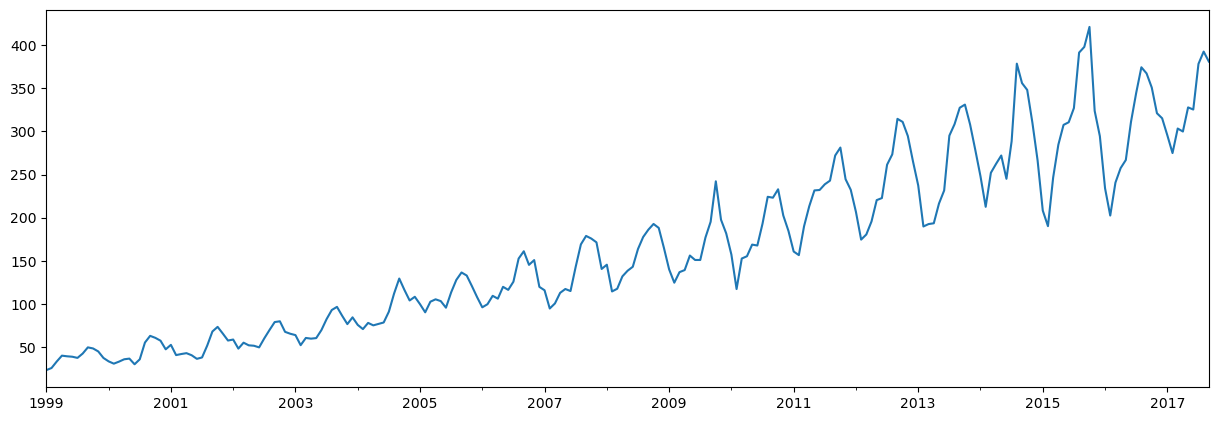

In [11]:
DATA[1].plot(figsize=(15,5))

In [12]:
TS = DATA[1]

# Stationary Test

In [13]:
def stationarity_test(ts):
    
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()

    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    # Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(ts, autolag='AIC')
    print(dftest)     
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)    

# Ploting decompostion

In [14]:
def plotting_decomposition(TS, trend, seas, res):
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].plot(TS, label='Original')
    axes[0].legend(loc='upper left');

    axes[1].plot(trend, label='Trend')
    axes[1].legend(loc='upper left');
 
    axes[2].plot(seas, label='Seasonality')
    axes[2].legend(loc='upper left');

    axes[3].plot(res, label='Residuals')
    axes[3].legend(loc='upper left');

# Decomposition

In [15]:
def decom(TS, model):
    ss_decomposition = seasonal_decompose(x=TS, model= model, freq=12)
    trend = ss_decomposition.trend
    seasonal = ss_decomposition.seasonal
    residual = ss_decomposition.resid
    return trend, seasonal, residual

# MSE

In [16]:
def mse(observations, estimates):
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    return mse

# Plotting Smoothing models

In [17]:
def plot_smooth(test, train, pred, name):
    plt.plot(train, 'b--', label="train")
    plt.plot(test, color='orange', linestyle="--", label="test")
    plt.plot(pred, 'r--', label="predictions")
    plt.legend(loc='upper left')
    plt.title(name)
    plt.grid(alpha=0.3);

# Smoothing models

In [18]:
def simple_avarage(TS, train, test):
    avg = np.mean(TS)
    avg_pred = np.full(shape=len(test), fill_value=avg, dtype='float')

    TS_mse = mse(test, avg)

    df_simple_avg = c.deepcopy(TS_ln[-12:])
    for i in range(12):
        df_simple_avg[i] = avg_pred[i]
    print("Predictions: ", avg_pred)
    print("MSE: ", TS_mse)
    return df_simple_avg

In [19]:
def single(train, test):
    single = SimpleExpSmoothing(train).fit(optimized=True)
    single_preds = single.forecast(len(test))
    single_mse = mse(test, single_preds)
    print("Predictions: ", single_preds)
    print("MSE: ", single_mse)
    return single_preds

In [20]:
def double(train, test):
    double = Holt(train).fit(optimized=True)
    double_preds = double.forecast(len(test))
    double_mse = mse(test, double_preds)
    print("Predictions: ", double_preds)
    print("MSE: ", double_mse)
    return double_preds

In [21]:
def triple(train,test):
    triple = ExponentialSmoothing(train,
                              trend="add",
                              seasonal="add",
                              seasonal_periods=13).fit(optimized=True)
    triple_preds = triple.forecast(len(test))
    triple_mse = mse(test, triple_preds)
    print("Predictions: ", triple_preds)
    print("MSE: ", triple_mse)
    return triple_preds

# Raw data: stationary and smoothing

Results of Dickey-Fuller Test:
(1.0625537814707104, 0.9948840159138252, 12, 212, {'1%': -3.4615775784078466, '5%': -2.875271898983725, '10%': -2.5740891037735847}, 1722.9651945586925)
Test Statistic                   1.062554
p-value                          0.994884
#Lags Used                      12.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


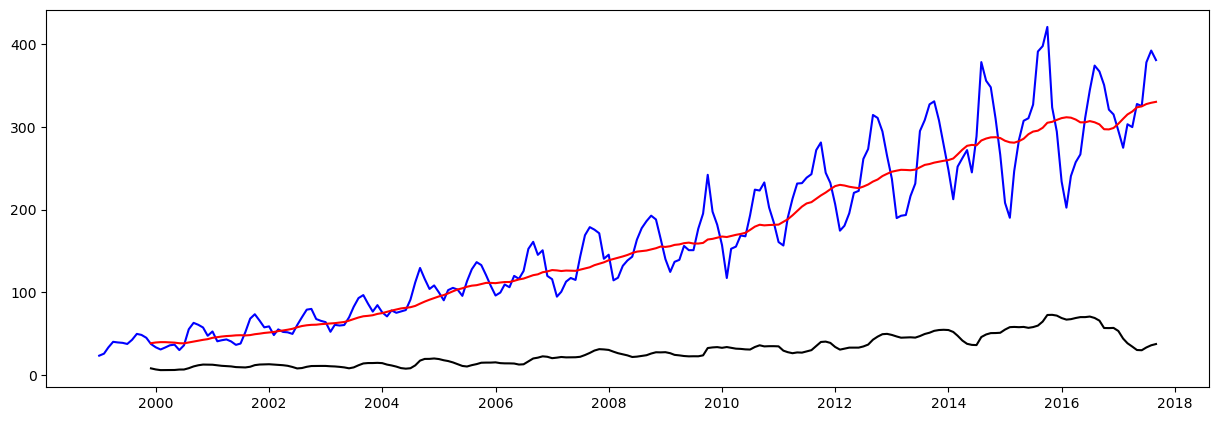

In [22]:
TS.dropna(inplace=True)
stationarity_test(TS)

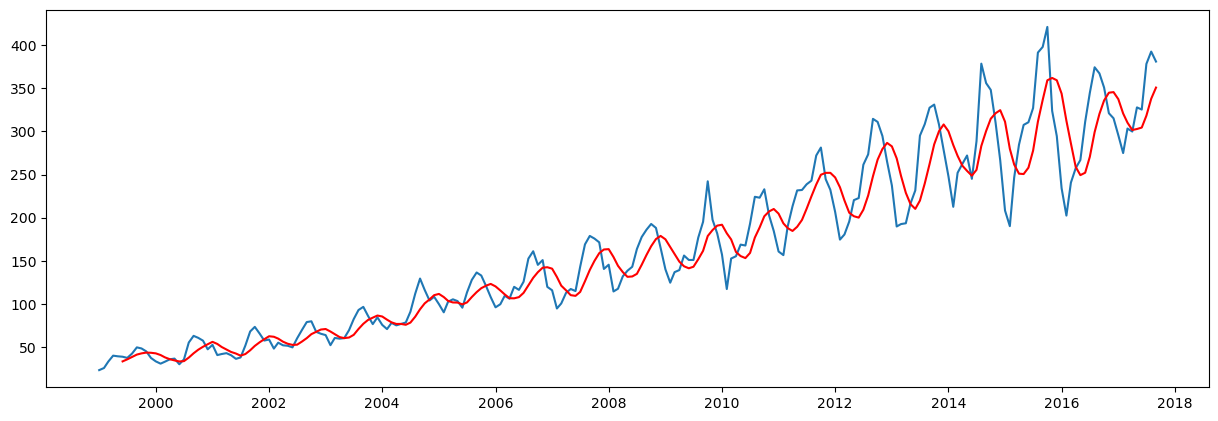

In [23]:
TS_moving_avg = TS.rolling(6, center=False).mean()
plt.plot(TS)
plt.plot(TS_moving_avg, color='red')

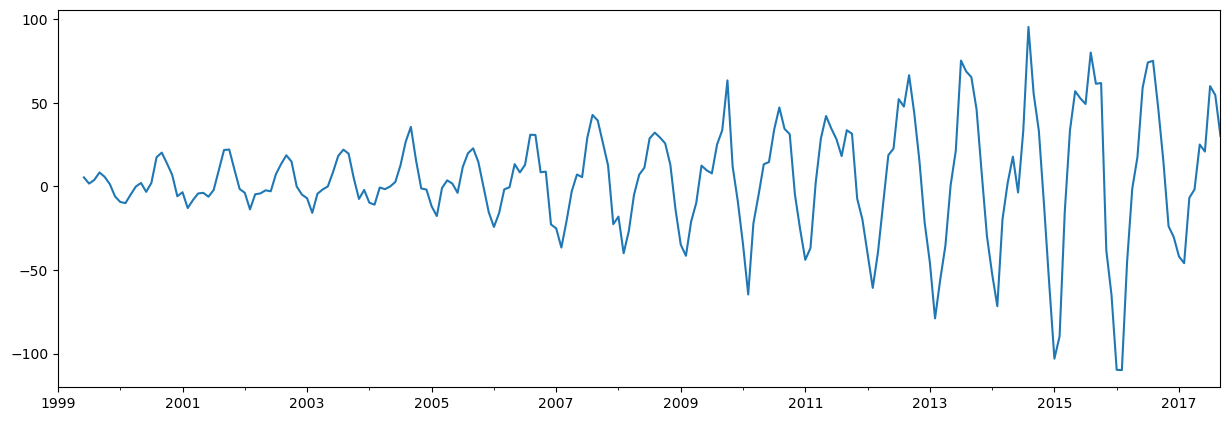

In [24]:
TS_ma_diff = TS - TS_moving_avg
TS_ma_diff.plot()

Results of Dickey-Fuller Test:
(-6.210471102093004, 5.523599723804582e-08, 12, 207, {'1%': -3.4623415245233145, '5%': -2.875606128263243, '10%': -2.574267439846904}, 1612.451729380094)
Test Statistic                -6.210471e+00
p-value                        5.523600e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.070000e+02
Critical Value (1%)           -3.462342e+00
Critical Value (5%)           -2.875606e+00
Critical Value (10%)          -2.574267e+00
dtype: float64


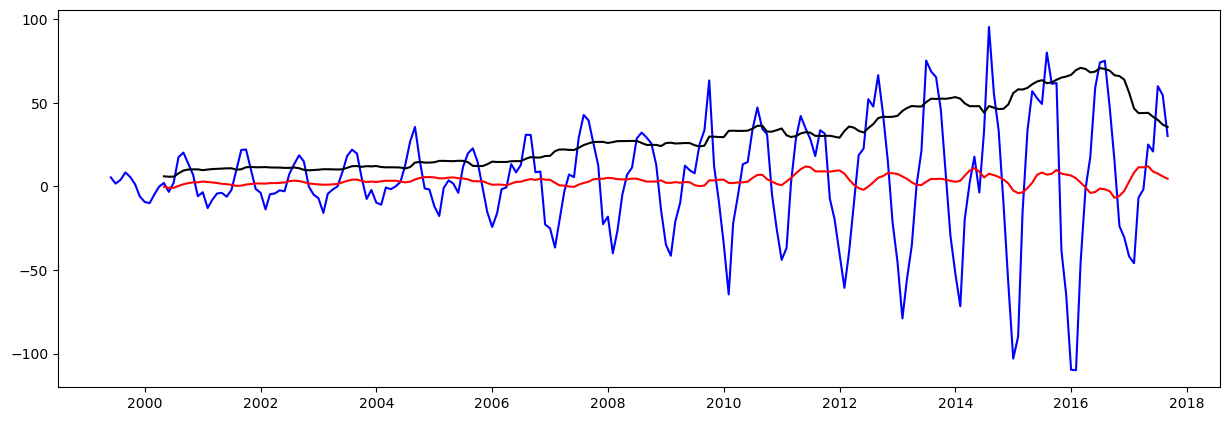

In [25]:
TS_ma_diff.dropna(inplace=True)
stationarity_test(TS_ma_diff)

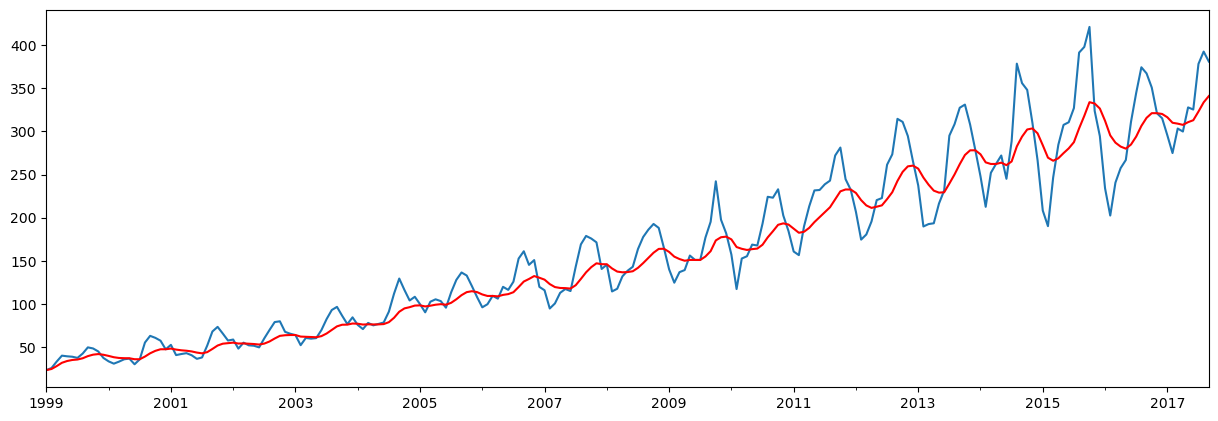

In [26]:
expwighted_avg = TS.ewm(span=12).mean()
TS.plot()
expwighted_avg.plot(color="red", label="EWMA")

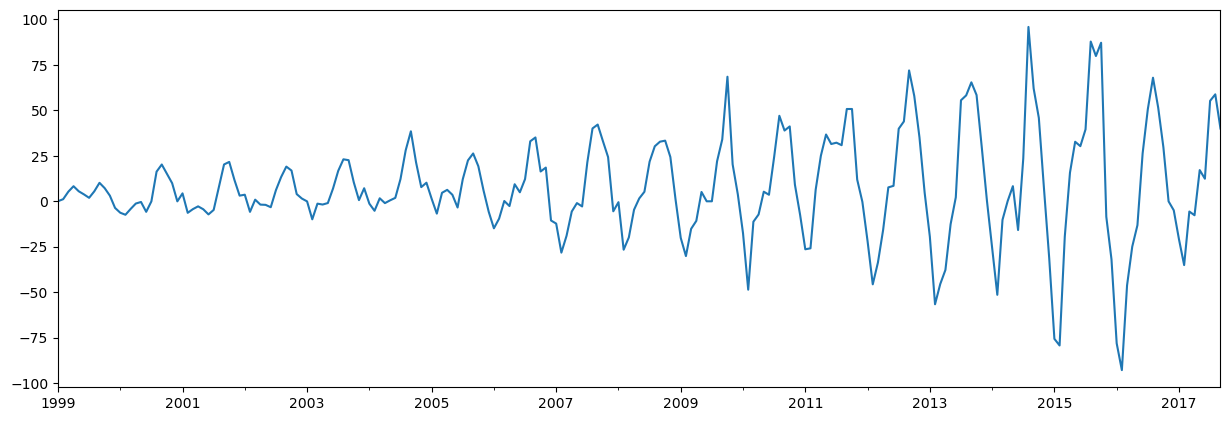

In [27]:
TS_exp_diff = TS - expwighted_avg
TS_exp_diff.plot()

Results of Dickey-Fuller Test:
(-4.274826471920266, 0.0004909769337945703, 12, 212, {'1%': -3.4615775784078466, '5%': -2.875271898983725, '10%': -2.5740891037735847}, 1652.404167150791)
Test Statistic                  -4.274826
p-value                          0.000491
#Lags Used                      12.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


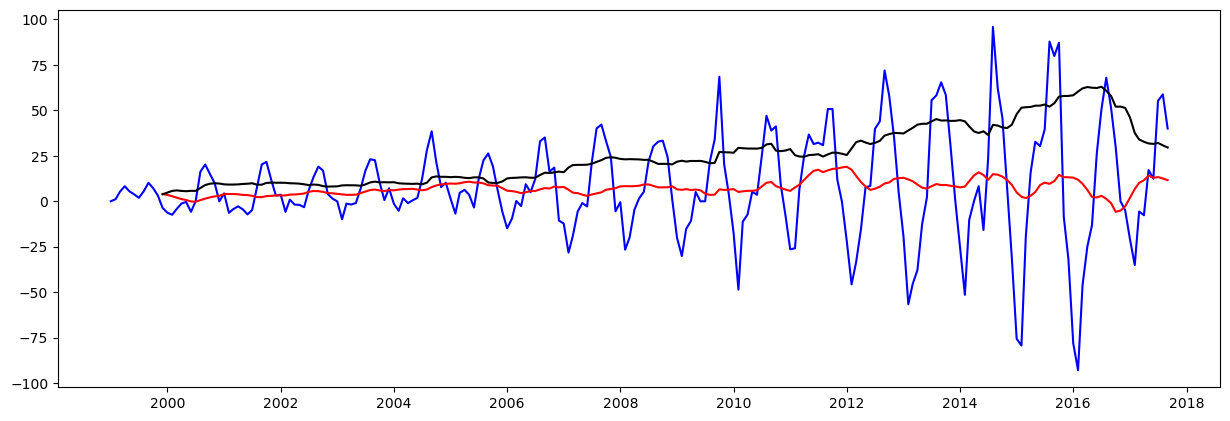

In [28]:
stationarity_test(TS_exp_diff)

# Raw data: add vs mul

In [29]:
trend_a, seasonal_a, residual_a = decom(TS, 'add') 

c:\users\home\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


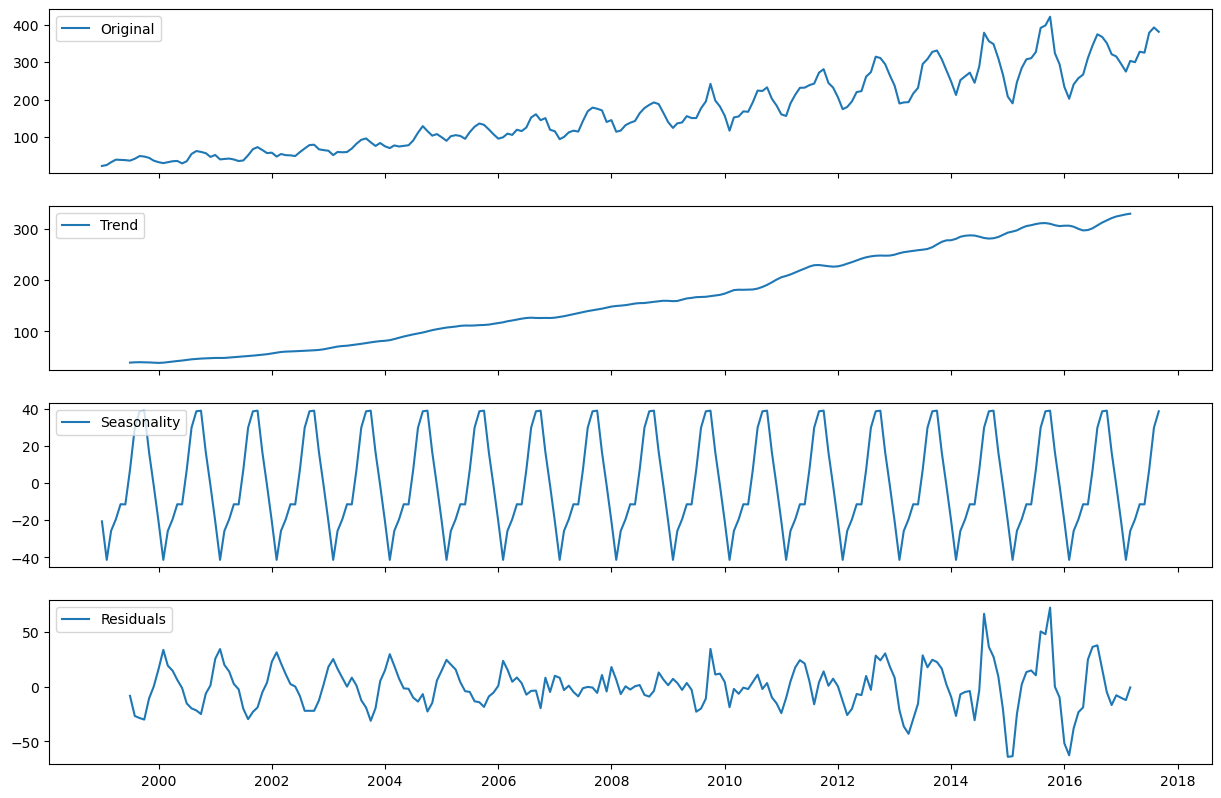

In [30]:
plotting_decomposition(TS, trend_a, seasonal_a, residual_a)

Results of Dickey-Fuller Test:
(-7.08125829947219, 4.660002788020187e-10, 15, 197, {'1%': -3.463987334463603, '5%': -2.8763259091636213, '10%': -2.5746515171738515}, 1510.1962198277445)
Test Statistic                -7.081258e+00
p-value                        4.660003e-10
#Lags Used                     1.500000e+01
Number of Observations Used    1.970000e+02
Critical Value (1%)           -3.463987e+00
Critical Value (5%)           -2.876326e+00
Critical Value (10%)          -2.574652e+00
dtype: float64


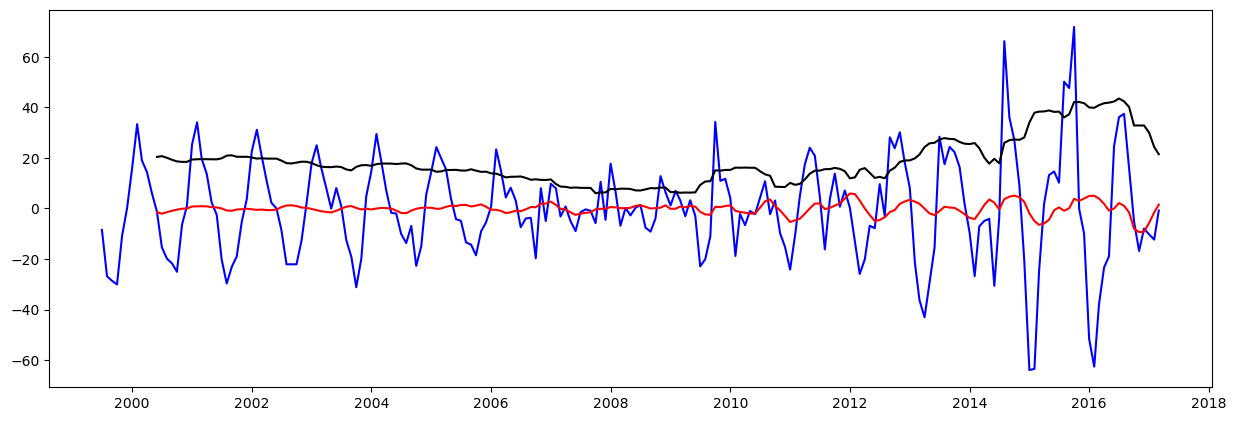

In [31]:
residual_a.dropna(inplace=True)
stationarity_test(residual_a)

In [32]:
trend_m, seasonal_m, residual_m = decom(TS, 'mul')

c:\users\home\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


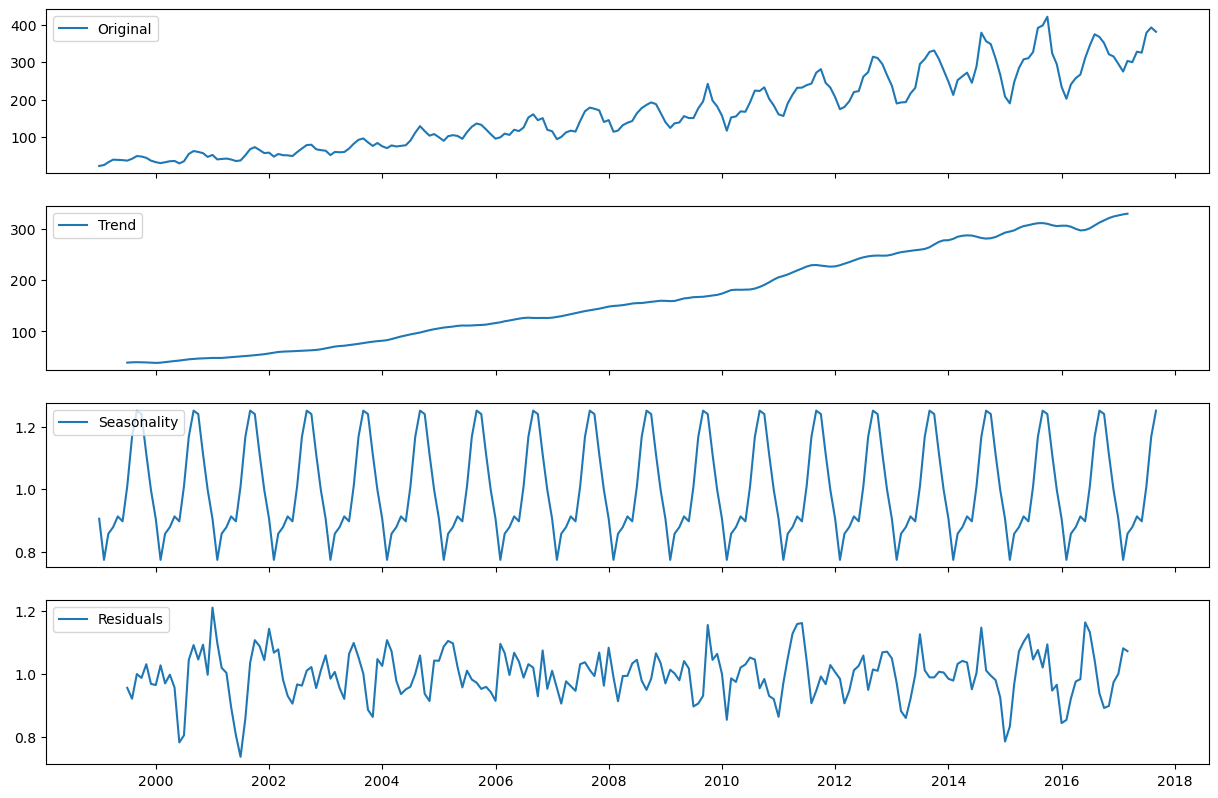

In [33]:
plotting_decomposition(TS, trend_m, seasonal_m, residual_m)

Results of Dickey-Fuller Test:
(-7.465788058856588, 5.2090400353165676e-11, 14, 198, {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}, -577.5956965150076)
Test Statistic                -7.465788e+00
p-value                        5.209040e-11
#Lags Used                     1.400000e+01
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64


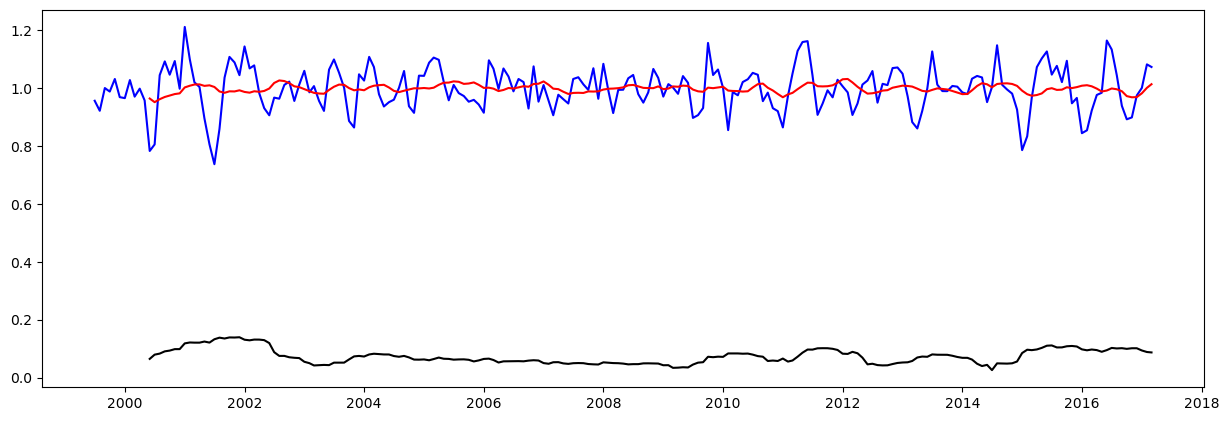

In [34]:
residual_m.dropna(inplace=True)
stationarity_test(residual_m)

# Ln data: stationary and smoothing


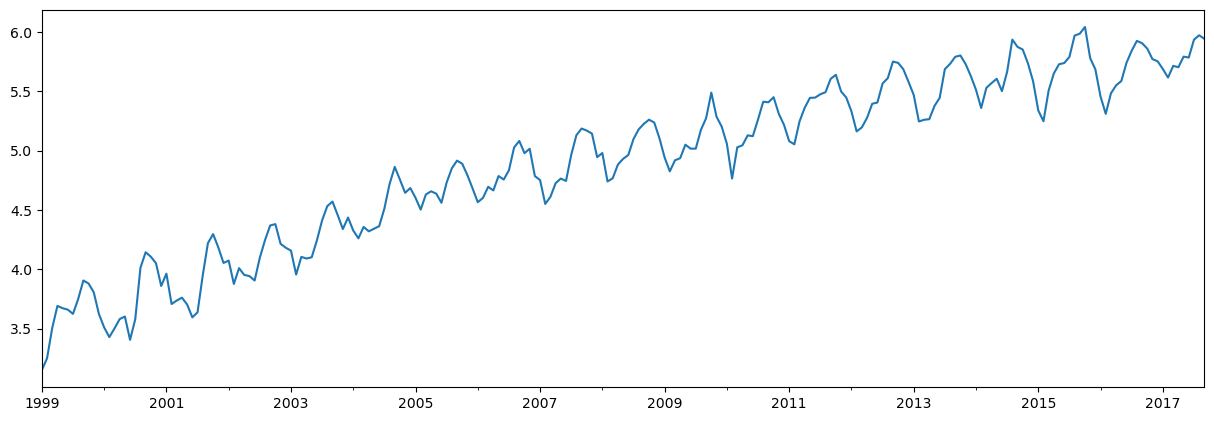

In [35]:
TS_ln = np.log(TS)
TS_ln.plot()

Results of Dickey-Fuller Test:
(-3.260565368096715, 0.016735894686959383, 15, 209, {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}, -460.62396896342557)
Test Statistic                  -3.260565
p-value                          0.016736
#Lags Used                      15.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


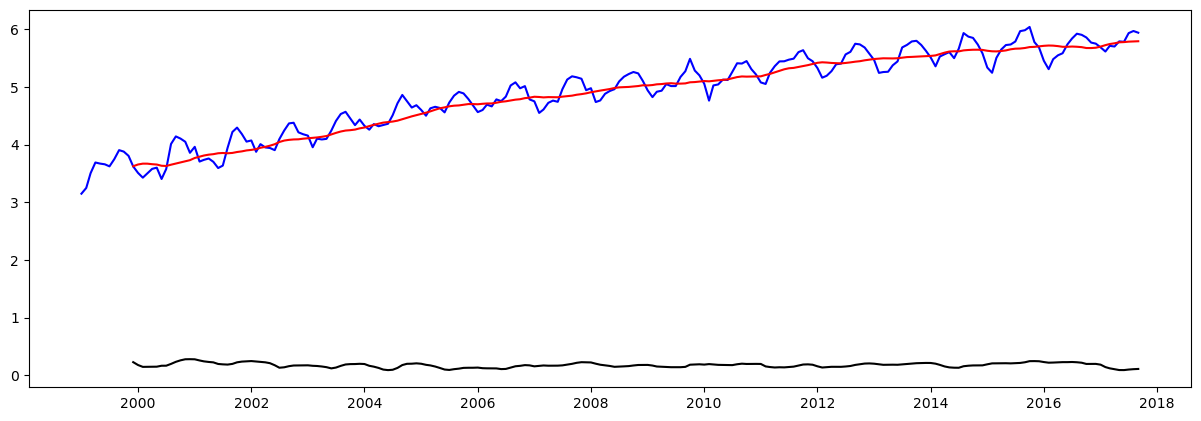

In [36]:
TS_ln.dropna(inplace=True)
stationarity_test(TS_ln)

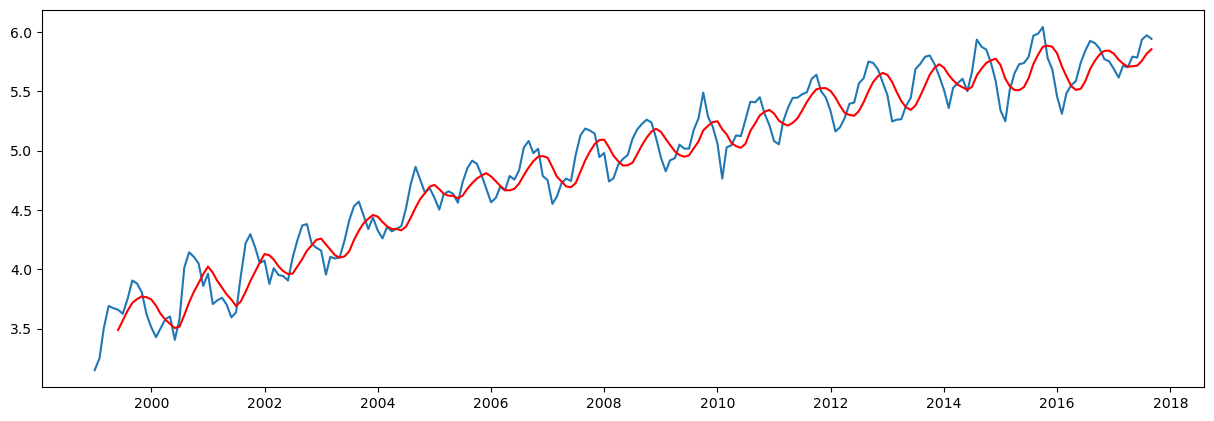

In [37]:
TS_moving_avg_ln = TS_ln.rolling(6, center=False).mean()
plt.plot(TS_ln)
plt.plot(TS_moving_avg_ln, color='red')

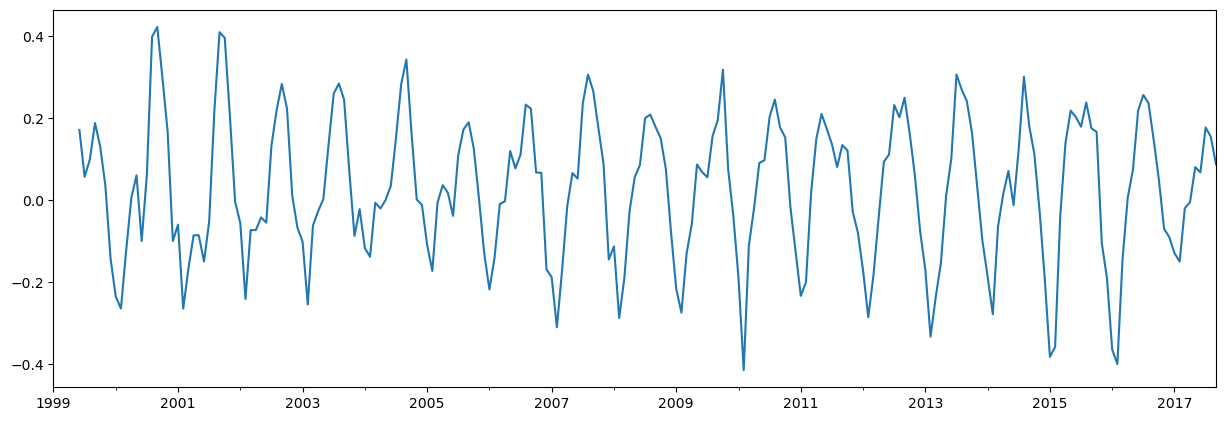

In [38]:
TS_ma_diff_ln = TS_ln - TS_moving_avg_ln
TS_ma_diff_ln.plot()

Results of Dickey-Fuller Test:
(-6.365583257651036, 2.4145096593798157e-08, 12, 207, {'1%': -3.4623415245233145, '5%': -2.875606128263243, '10%': -2.574267439846904}, -529.7738528353334)
Test Statistic                -6.365583e+00
p-value                        2.414510e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.070000e+02
Critical Value (1%)           -3.462342e+00
Critical Value (5%)           -2.875606e+00
Critical Value (10%)          -2.574267e+00
dtype: float64


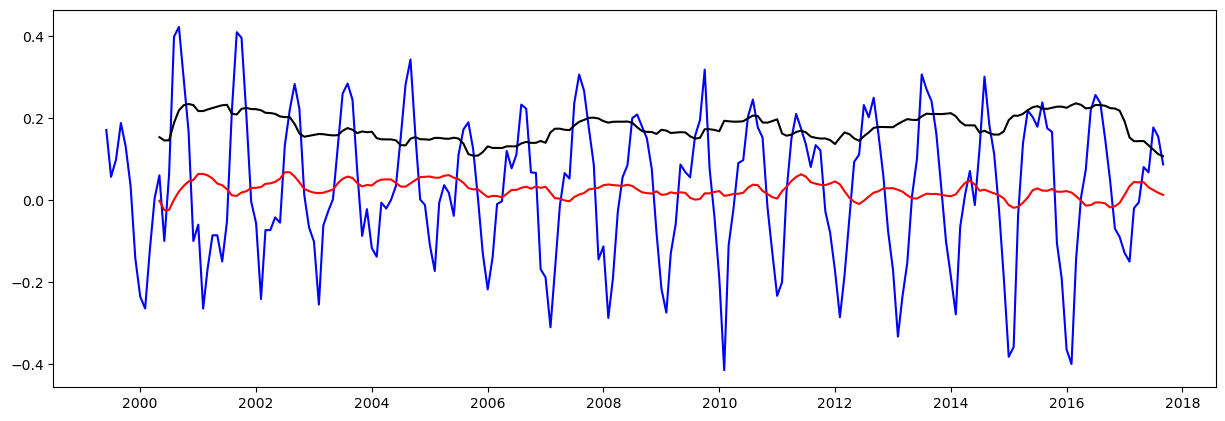

In [39]:
TS_ma_diff_ln.dropna(inplace=True)
stationarity_test(TS_ma_diff_ln)

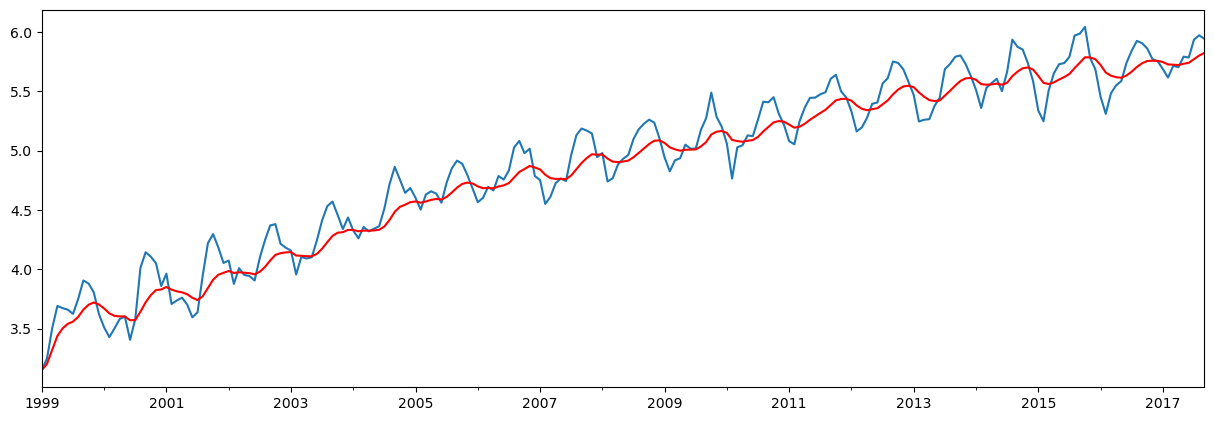

In [40]:
expwighted_avg_ln = TS_ln.ewm(span=12).mean()
TS_ln.plot()
expwighted_avg_ln.plot(color="red", label="EWMA")

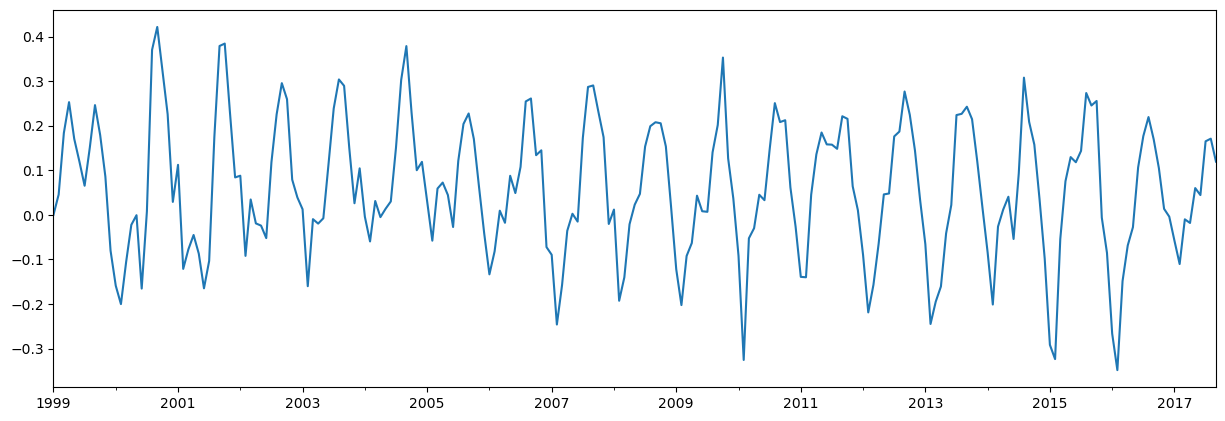

In [41]:
TS_exp_diff_ln = TS_ln - expwighted_avg_ln
TS_exp_diff_ln.plot()

Results of Dickey-Fuller Test:
(-2.9700738095295187, 0.037785224445415454, 15, 209, {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}, -518.9858279226762)
Test Statistic                  -2.970074
p-value                          0.037785
#Lags Used                      15.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


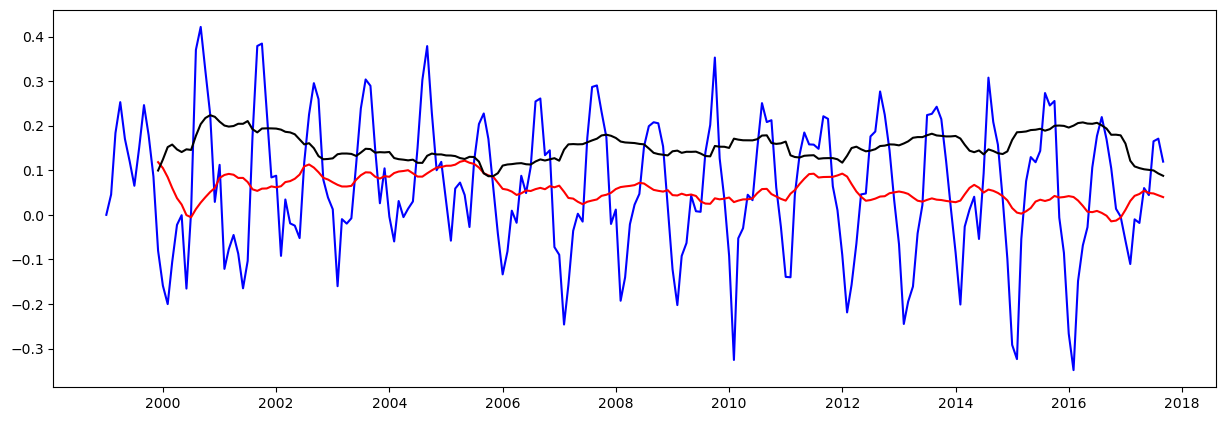

In [42]:
TS_exp_diff_ln.dropna(inplace=True)
stationarity_test(TS_exp_diff_ln)

# Ln data: add vs mul

In [43]:
ln_trend_a, ln_seasonal_a, ln_residual_a = decom(TS_ln, 'add')

c:\users\home\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


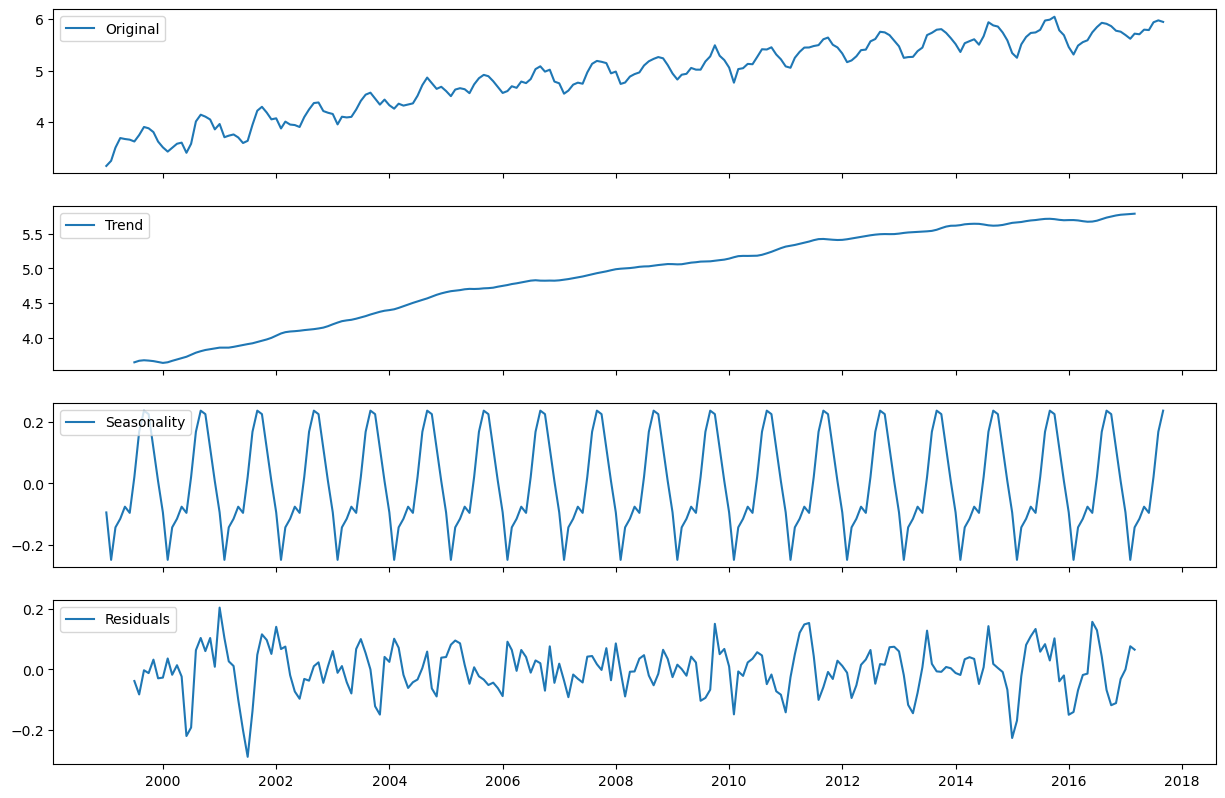

In [44]:
plotting_decomposition(TS_ln, ln_trend_a, ln_seasonal_a, ln_residual_a)

Results of Dickey-Fuller Test:
(-8.404464534751485, 2.1865376657576418e-13, 14, 198, {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}, -586.8220572828895)
Test Statistic                -8.404465e+00
p-value                        2.186538e-13
#Lags Used                     1.400000e+01
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64


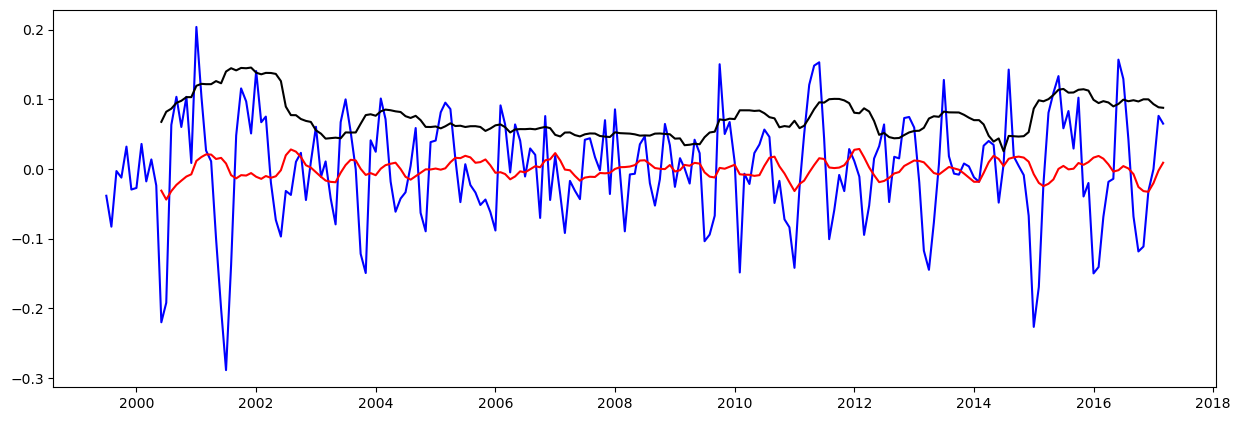

In [45]:
ln_residual_a.dropna(inplace=True)
stationarity_test(ln_residual_a)

In [46]:
ln_trend_m, ln_seasonal_m, ln_residual_m = decom(TS_ln, 'mul')

c:\users\home\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


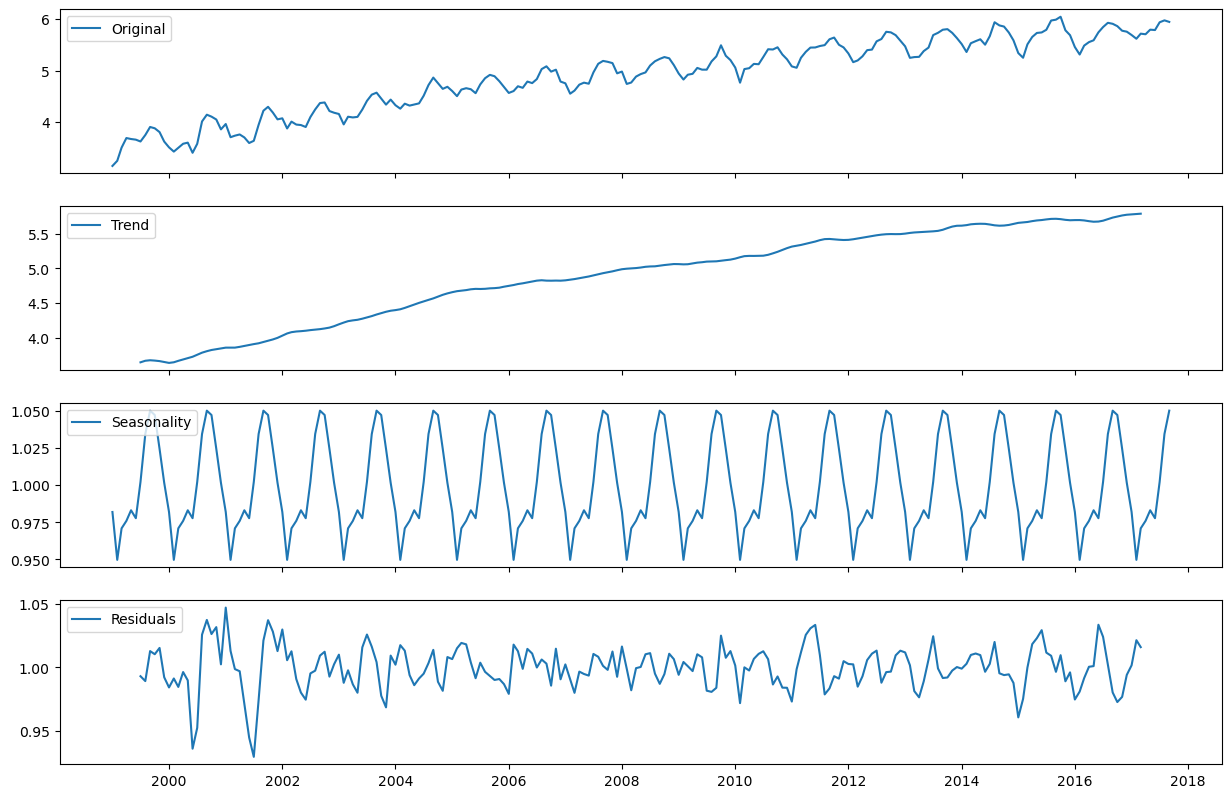

In [47]:
plotting_decomposition(TS_ln, ln_trend_m, ln_seasonal_m, ln_residual_m)

Results of Dickey-Fuller Test:
(-8.603728682557284, 6.759985210553787e-14, 14, 198, {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}, -1206.7315653825617)
Test Statistic                -8.603729e+00
p-value                        6.759985e-14
#Lags Used                     1.400000e+01
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64


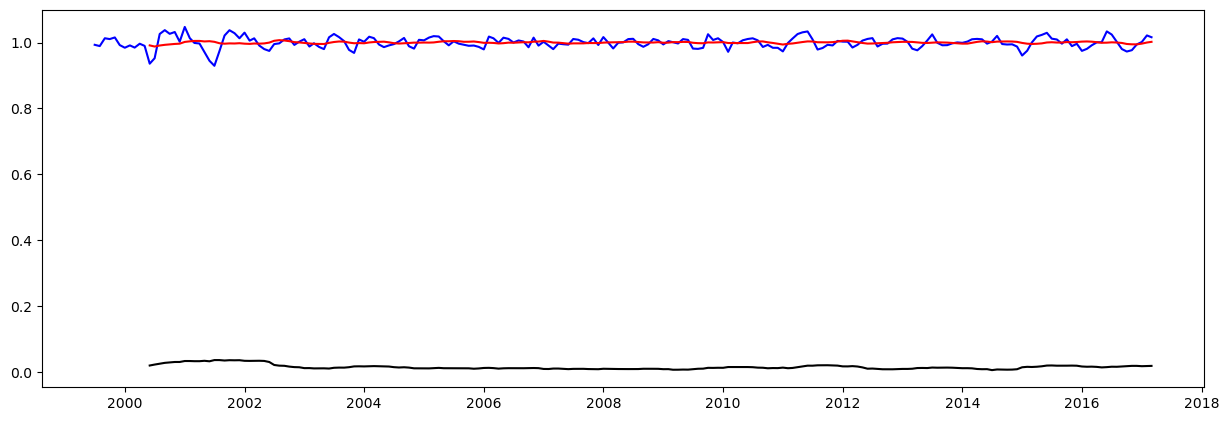

In [48]:
ln_residual_m.dropna(inplace=True)
stationarity_test(ln_residual_m)

# Differencing

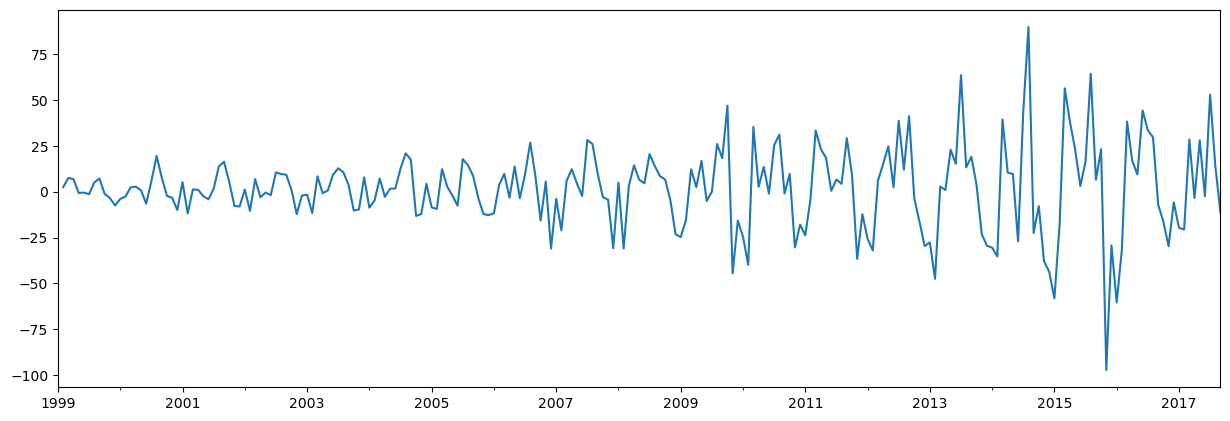

In [49]:
TS_diff = TS - TS.shift(1)
TS_diff.plot()

Results of Dickey-Fuller Test:
(-7.284619545794558, 1.4698750464902985e-10, 11, 212, {'1%': -3.4615775784078466, '5%': -2.875271898983725, '10%': -2.5740891037735847}, 1714.5443079463307)
Test Statistic                -7.284620e+00
p-value                        1.469875e-10
#Lags Used                     1.100000e+01
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


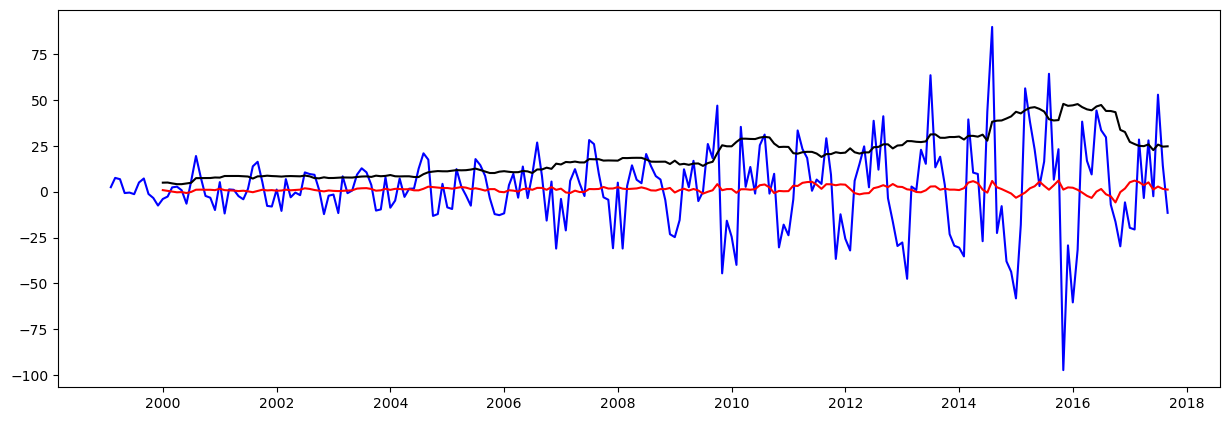

In [50]:
TS_diff.dropna(inplace=True)
stationarity_test(TS_diff)

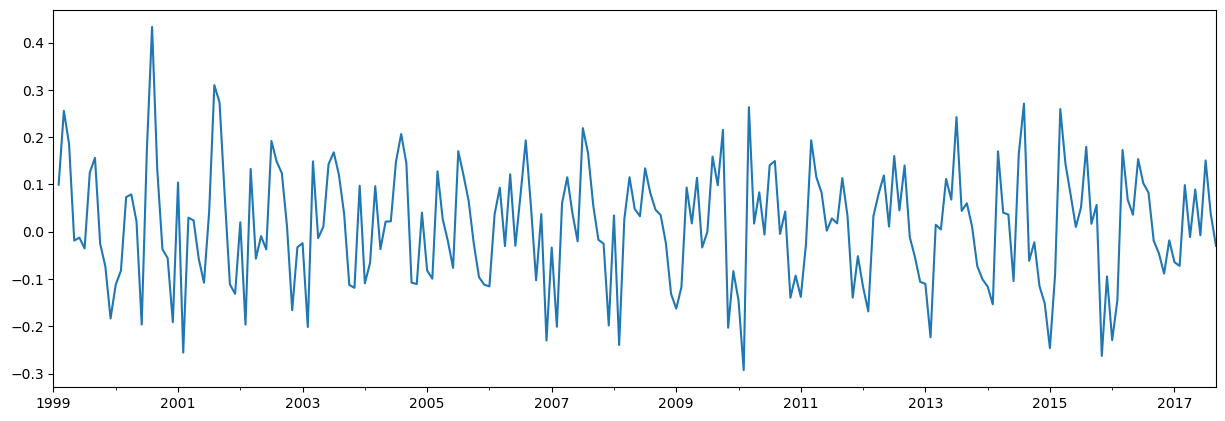

In [51]:
TS_diff_ln = TS_ln - TS_ln.shift(1)
TS_diff_ln.plot()

Results of Dickey-Fuller Test:
(-6.0279177164840725, 1.441030041324254e-07, 14, 209, {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}, -448.16854993215895)
Test Statistic                -6.027918e+00
p-value                        1.441030e-07
#Lags Used                     1.400000e+01
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


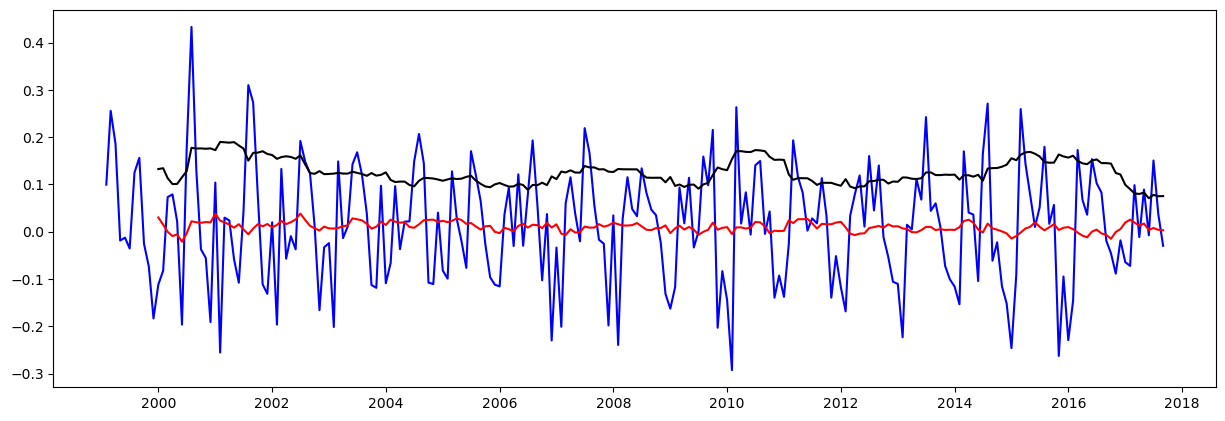

In [52]:
TS_diff_ln.dropna(inplace=True)
stationarity_test(TS_diff_ln)

# Smothing model(Raw data)


In [53]:
train = TS[:-12]
test = TS[-12:]

In [54]:
df_simple_avg = simple_avarage(TS, train, test)

Predictions:  [165.66674667 165.66674667 165.66674667 165.66674667 165.66674667
 165.66674667 165.66674667 165.66674667 165.66674667 165.66674667
 165.66674667 165.66674667]
MSE:  341095.7645839701


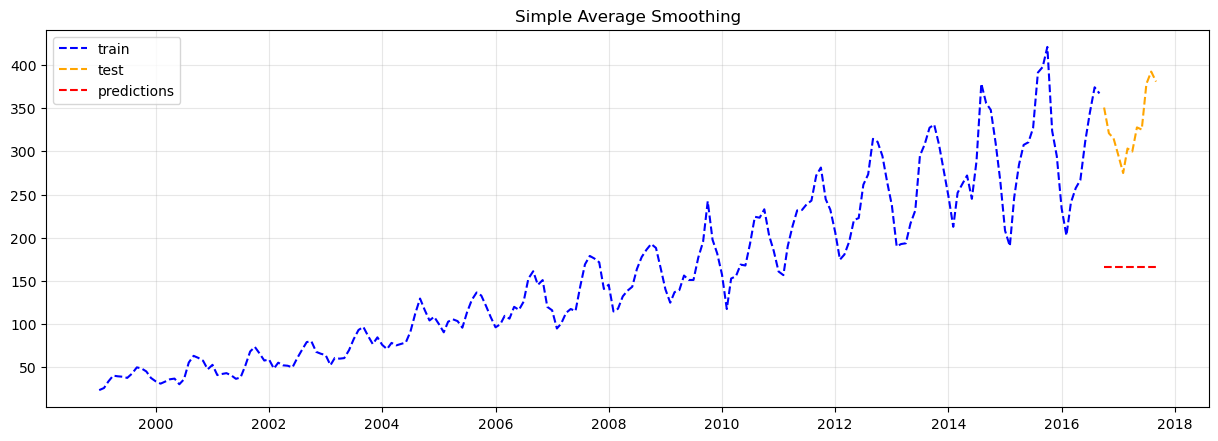

In [55]:
plot_smooth(test, train, df_simple_avg, "Simple Average Smoothing")

In [56]:
single_preds = single(train,test)

Predictions:  2016-10-01    367.147
2016-11-01    367.147
2016-12-01    367.147
2017-01-01    367.147
2017-02-01    367.147
2017-03-01    367.147
2017-04-01    367.147
2017-05-01    367.147
2017-06-01    367.147
2017-07-01    367.147
2017-08-01    367.147
2017-09-01    367.147
Freq: MS, dtype: float64
MSE:  31621.4830574201


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


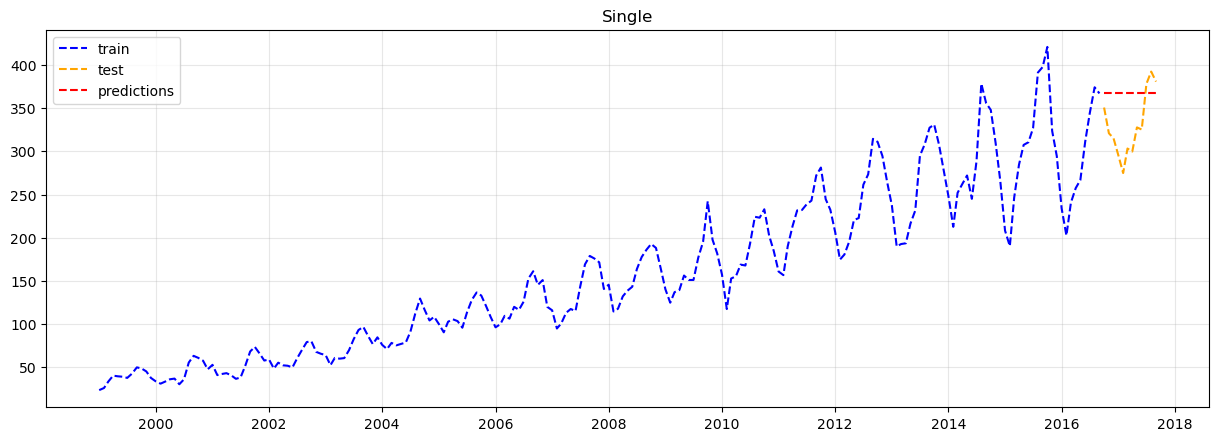

In [57]:
plot_smooth(test, train, single_preds, "Single")

In [58]:
double_preds = double(train, test)

Predictions:  2016-10-01    368.807642
2016-11-01    370.424330
2016-12-01    372.041018
2017-01-01    373.657706
2017-02-01    375.274394
2017-03-01    376.891082
2017-04-01    378.507770
2017-05-01    380.124458
2017-06-01    381.741146
2017-07-01    383.357834
2017-08-01    384.974523
2017-09-01    386.591211
Freq: MS, dtype: float64
MSE:  39856.063149405934


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


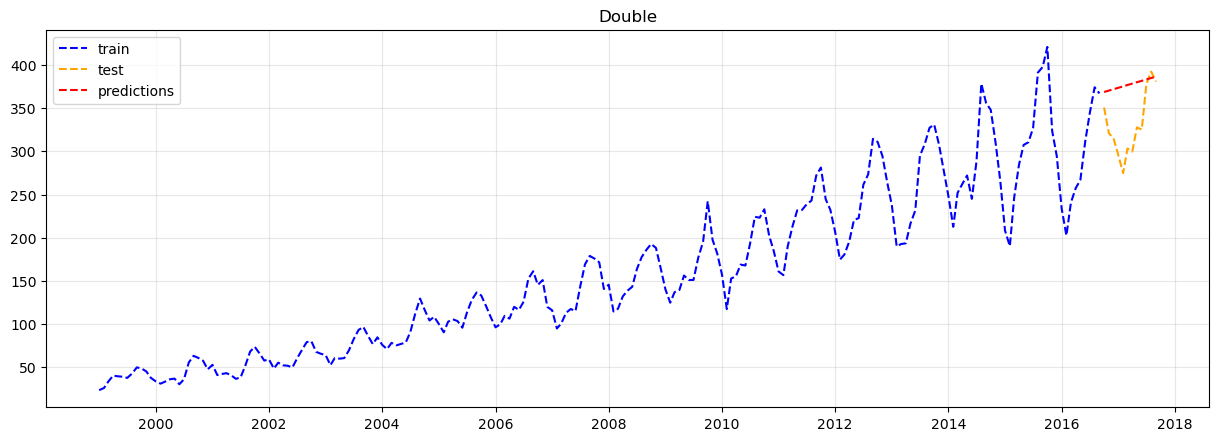

In [59]:
plot_smooth(test, train, double_preds, "Double")

In [60]:
triple_preds = triple(train, test)

c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Predictions:  2016-10-01    375.669932
2016-11-01    376.823680
2016-12-01    374.965717
2017-01-01    378.621611
2017-02-01    374.983262
2017-03-01    371.846835
2017-04-01    373.222759
2017-05-01    375.179976
2017-06-01    374.152809
2017-07-01    376.071490
2017-08-01    375.938707
2017-09-01    378.141479
Freq: MS, dtype: float64
MSE:  39263.36852023688


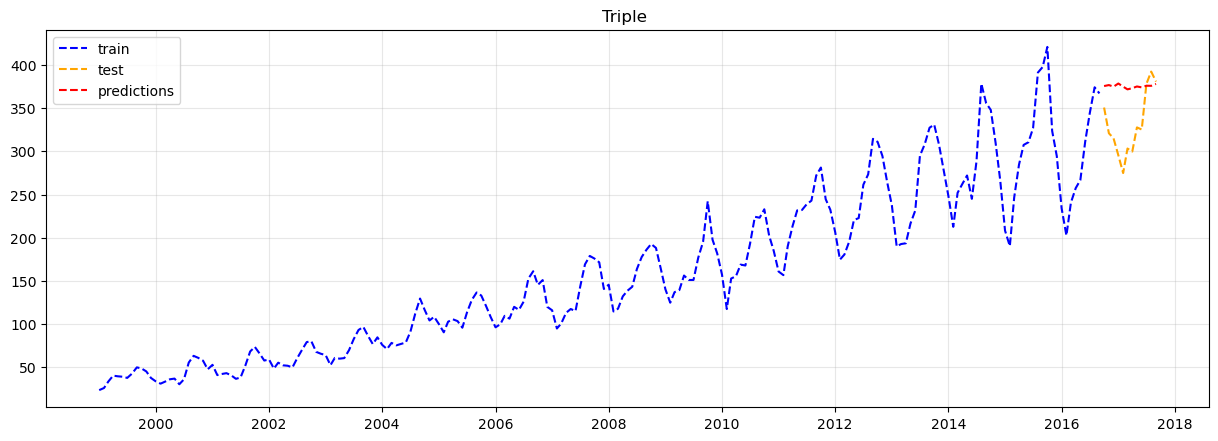

In [61]:
plot_smooth(test, train, triple_preds, "Triple ")

# Smoothing model(Ln data)

In [62]:
train_ln = TS_ln[:-12]
test_ln = TS_ln[-12:]

In [63]:
simple_avg_preds_ln = simple_avarage(TS_ln, train_ln, test_ln)

Predictions:  [4.88917905 4.88917905 4.88917905 4.88917905 4.88917905 4.88917905
 4.88917905 4.88917905 4.88917905 4.88917905 4.88917905 4.88917905]
MSE:  9.973886726945699


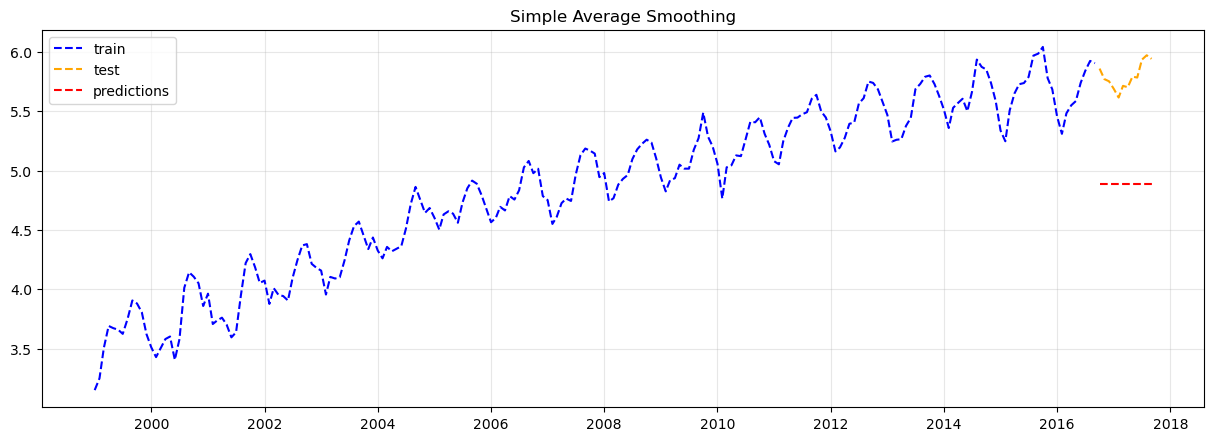

In [65]:
plot_smooth(test_ln, train_ln, simple_avg_preds_ln, "Simple Average Smoothing")

In [70]:
single_preds_ln = single(train_ln, test_ln)

Predictions:  2016-10-01    5.905762
2016-11-01    5.905762
2016-12-01    5.905762
2017-01-01    5.905762
2017-02-01    5.905762
2017-03-01    5.905762
2017-04-01    5.905762
2017-05-01    5.905762
2017-06-01    5.905762
2017-07-01    5.905762
2017-08-01    5.905762
2017-09-01    5.905762
Freq: MS, dtype: float64
MSE:  0.2861923345756687


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


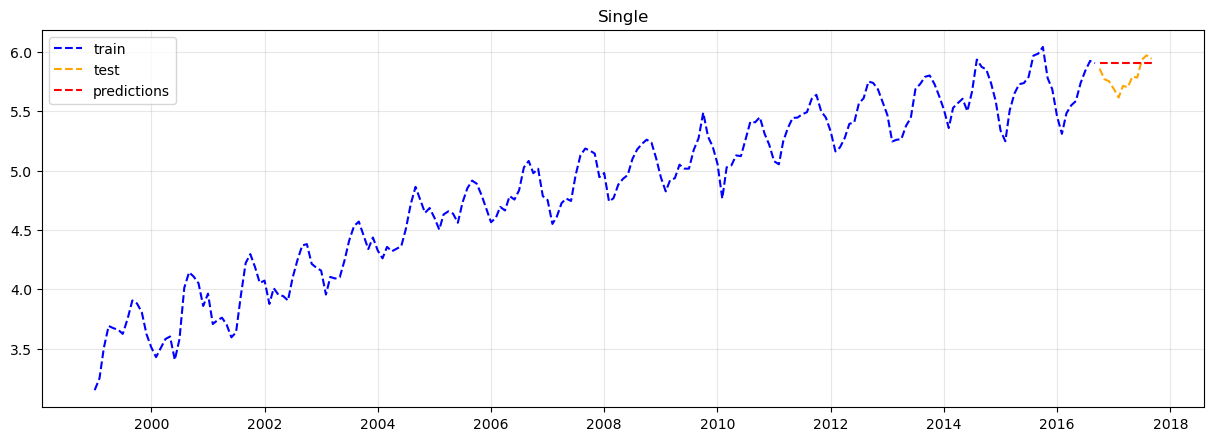

In [71]:
plot_smooth(test_ln, train_ln, single_preds_ln, "Single")

In [72]:
double_preds_ln = double(train_ln, test_ln)

Predictions:  2016-10-01    5.918756
2016-11-01    5.931750
2016-12-01    5.944744
2017-01-01    5.957738
2017-02-01    5.970732
2017-03-01    5.983727
2017-04-01    5.996721
2017-05-01    6.009715
2017-06-01    6.022709
2017-07-01    6.035703
2017-08-01    6.048697
2017-09-01    6.061691
Freq: MS, dtype: float64
MSE:  0.5565854576033379


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


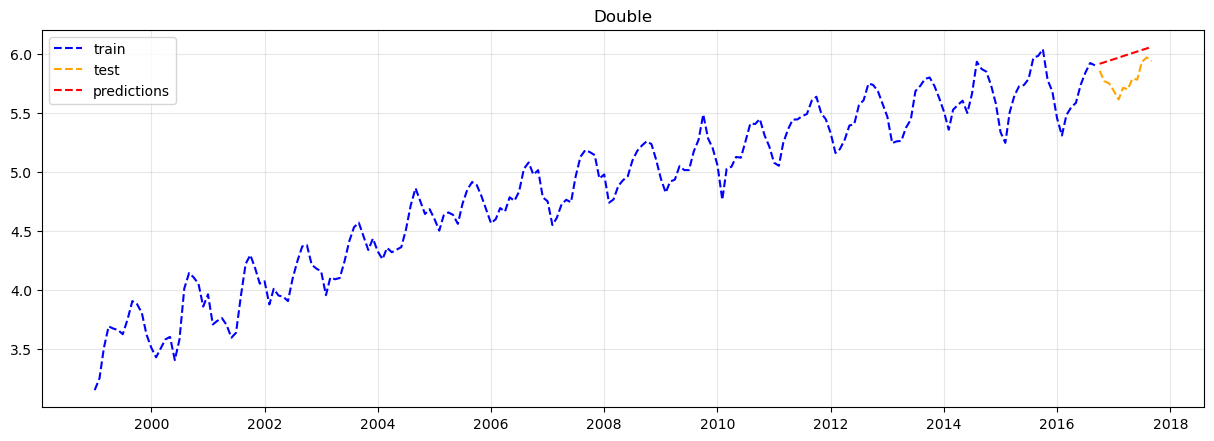

In [73]:
plot_smooth(test_ln, train_ln, double_preds_ln, "Double")

In [76]:
triple_preds_ln = triple(train_ln, test_ln)

c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Predictions:  2016-10-01    5.950738
2016-11-01    5.989183
2016-12-01    6.010897
2017-01-01    6.016321
2017-02-01    5.995165
2017-03-01    5.967164
2017-04-01    5.963849
2017-05-01    5.968467
2017-06-01    5.974070
2017-07-01    6.003871
2017-08-01    6.029352
2017-09-01    6.048598
Freq: MS, dtype: float64
MSE:  0.5909149708429977


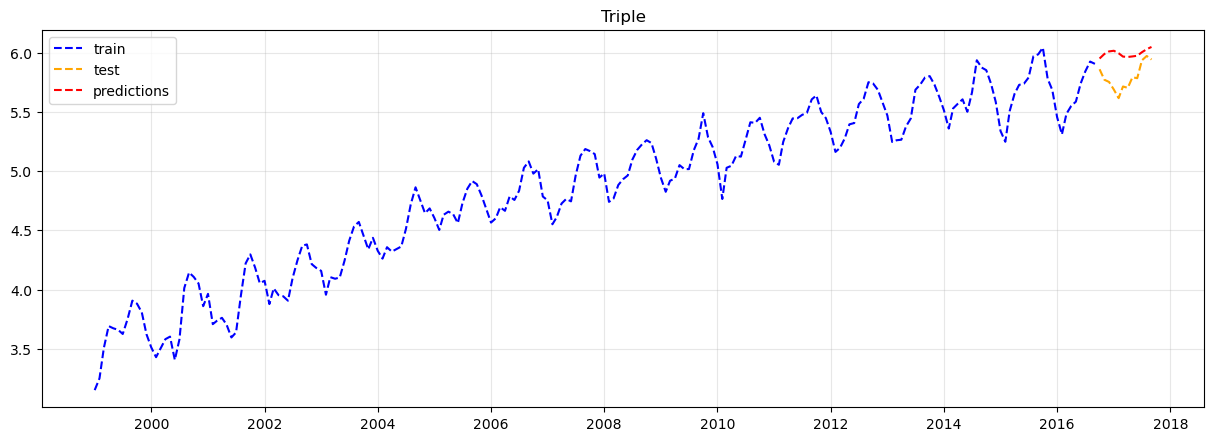

In [77]:
plot_smooth(test_ln, train_ln, triple_preds_ln, "Triple")

 # Smoothing model(Raw add decom)

In [78]:
train_add = residual_a[:-12]
test_add = residual_a[-12:]

In [80]:
simple_avg_preds_add = simple_avarage(residual_a, train_add, test_add)

Predictions:  [-0.39000284 -0.39000284 -0.39000284 -0.39000284 -0.39000284 -0.39000284
 -0.39000284 -0.39000284 -0.39000284 -0.39000284 -0.39000284 -0.39000284]
MSE:  5124.342401018169


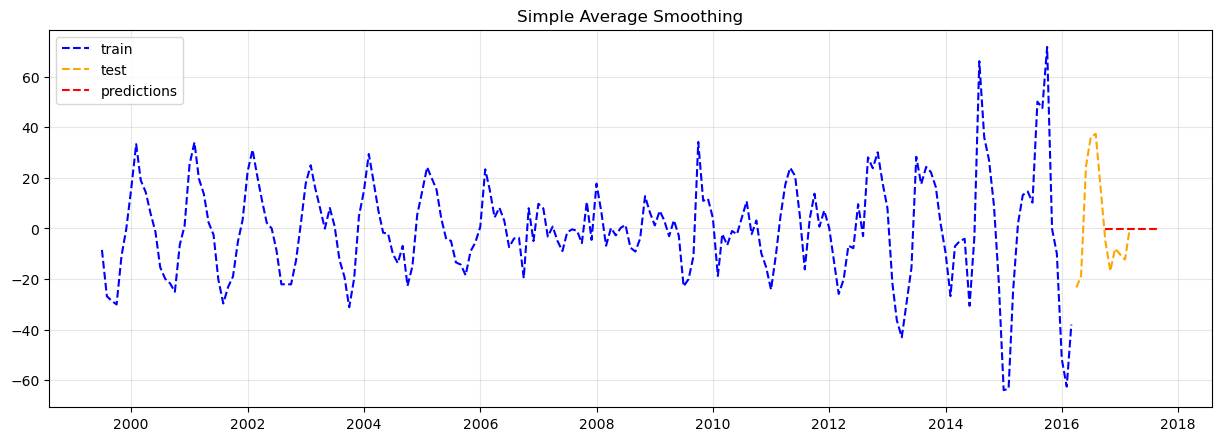

In [81]:
plot_smooth(test_add, train_add, simple_avg_preds_add, "Simple Average Smoothing")

In [82]:
single_preds_add = single(train_add, test_add)

Predictions:  2016-04-01   -38.036279
2016-05-01   -38.036279
2016-06-01   -38.036279
2016-07-01   -38.036279
2016-08-01   -38.036279
2016-09-01   -38.036279
2016-10-01   -38.036279
2016-11-01   -38.036279
2016-12-01   -38.036279
2017-01-01   -38.036279
2017-02-01   -38.036279
2017-03-01   -38.036279
Freq: MS, dtype: float64
MSE:  23879.27322338149


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


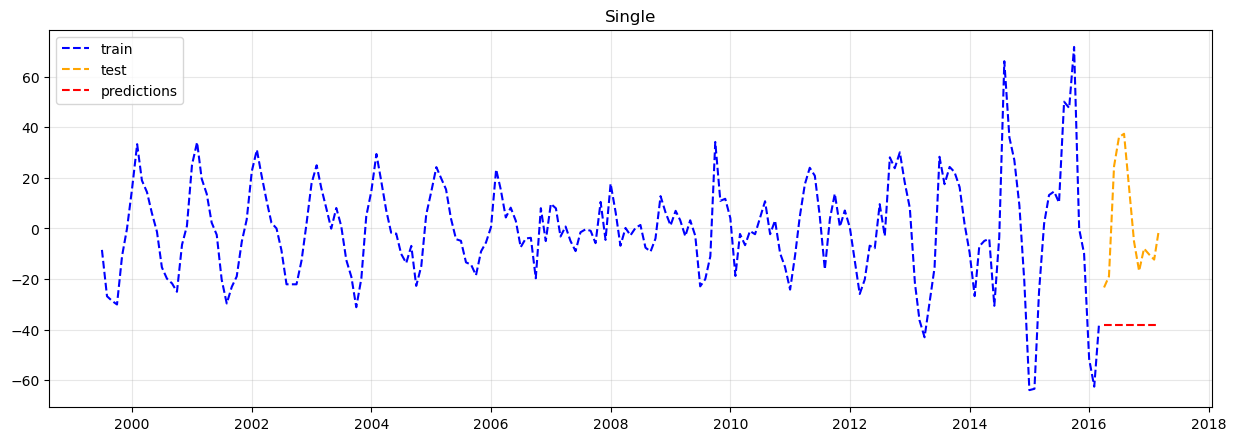

In [83]:
plot_smooth(test_add, train_add, single_preds_add, "Single")

In [84]:
double_preds_add = double(train_add, test_add)

Predictions:  2016-04-01   -38.173090
2016-05-01   -38.308513
2016-06-01   -38.443937
2016-07-01   -38.579360
2016-08-01   -38.714784
2016-09-01   -38.850207
2016-10-01   -38.985631
2016-11-01   -39.121055
2016-12-01   -39.256478
2017-01-01   -39.391902
2017-02-01   -39.527325
2017-03-01   -39.662749
Freq: MS, dtype: float64
MSE:  24682.565807859268


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


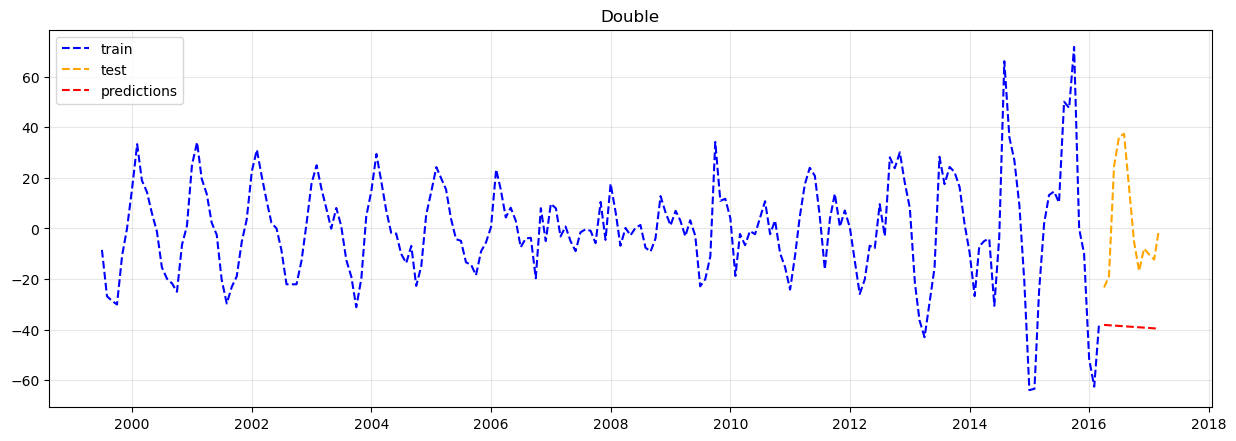

In [85]:
plot_smooth(test_add, train_add, double_preds_add, "Double")

In [86]:
triple_preds_add = triple(train_add, test_add)

c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Predictions:  2016-04-01   -26.309314
2016-05-01   -21.015063
2016-06-01   -28.075475
2016-07-01   -34.295167
2016-08-01   -40.062414
2016-09-01    -9.538492
2016-10-01     6.977493
2016-11-01     1.295936
2016-12-01   -42.249151
2017-01-01   -40.089295
2017-02-01   -56.709693
2017-03-01   -57.839084
Freq: MS, dtype: float64
MSE:  22179.963144815647


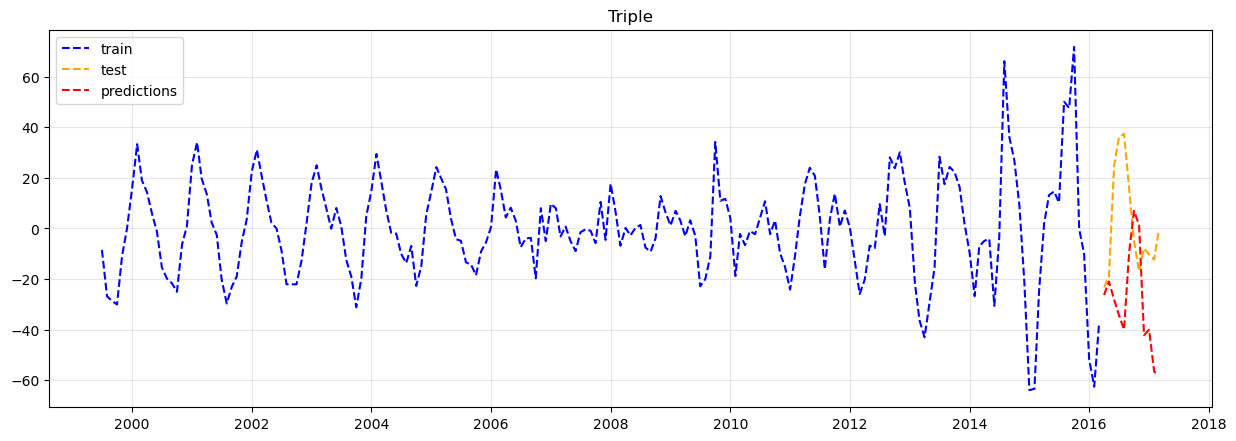

In [87]:
plot_smooth(test_add, train_add, triple_preds_add, "Triple")

 # Smoothing model(Raw mul decom)

In [93]:
train_mul = residual_m[:-12]
test_mul = residual_m[-12:]

In [94]:
simple_avg_preds_mul = simple_avarage(residual_m, train_mul, test_mul)


Predictions:  [0.99804448 0.99804448 0.99804448 0.99804448 0.99804448 0.99804448
 0.99804448 0.99804448 0.99804448 0.99804448 0.99804448 0.99804448]
MSE:  0.08650424339762397


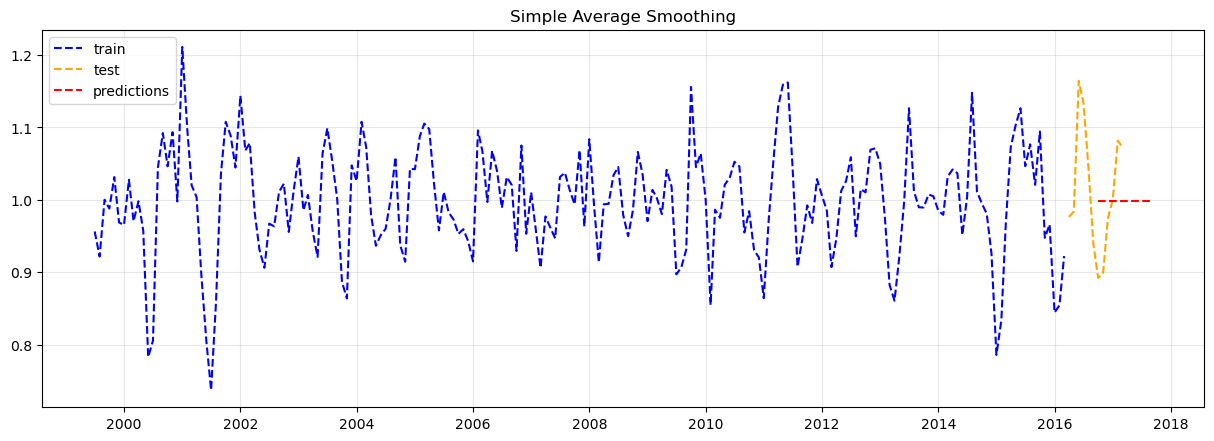

In [92]:
plot_smooth(test_mul, train_mul, simple_avg_preds_mul, "Simple Average Smoothing")

In [95]:
single_preds_mul = single(train_mul, test_mul)

Predictions:  2016-04-01    0.911547
2016-05-01    0.911547
2016-06-01    0.911547
2016-07-01    0.911547
2016-08-01    0.911547
2016-09-01    0.911547
2016-10-01    0.911547
2016-11-01    0.911547
2016-12-01    0.911547
2017-01-01    0.911547
2017-02-01    0.911547
2017-03-01    0.911547
Freq: MS, dtype: float64
MSE:  0.2083701572460583


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


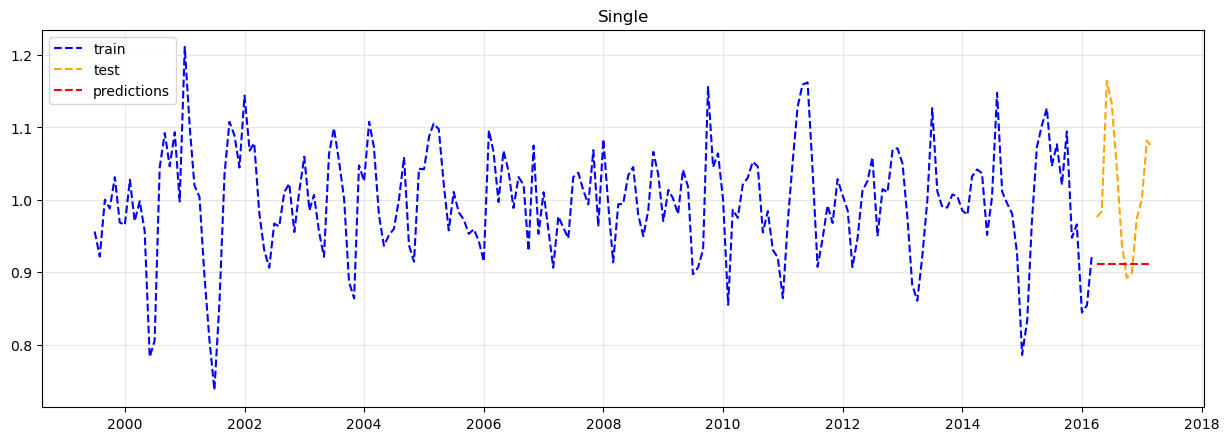

In [96]:
plot_smooth(test_mul, train_mul, single_preds_mul, "Single")

In [97]:
double_preds_mul = double(train_mul, test_mul)

Predictions:  2016-04-01    0.911283
2016-05-01    0.911069
2016-06-01    0.910856
2016-07-01    0.910642
2016-08-01    0.910428
2016-09-01    0.910214
2016-10-01    0.910000
2016-11-01    0.909786
2016-12-01    0.909573
2017-01-01    0.909359
2017-02-01    0.909145
2017-03-01    0.908931
Freq: MS, dtype: float64
MSE:  0.21182269185566116


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


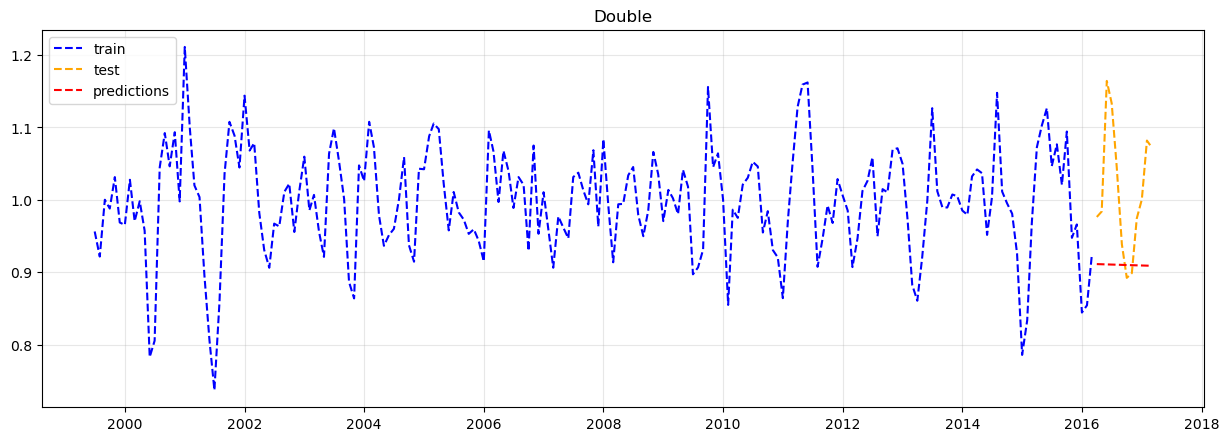

In [98]:
plot_smooth(test_mul, train_mul, double_preds_mul, "Double")

In [99]:
triple_preds_mul = triple(train_mul, test_mul)

c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Predictions:  2016-04-01    1.001889
2016-05-01    1.018737
2016-06-01    1.012823
2016-07-01    1.010006
2016-08-01    0.981074
2016-09-01    1.028738
2016-10-01    1.060383
2016-11-01    1.042930
2016-12-01    0.989688
2017-01-01    0.990136
2017-02-01    0.950018
2017-03-01    0.931357
Freq: MS, dtype: float64
MSE:  0.13892017703712234


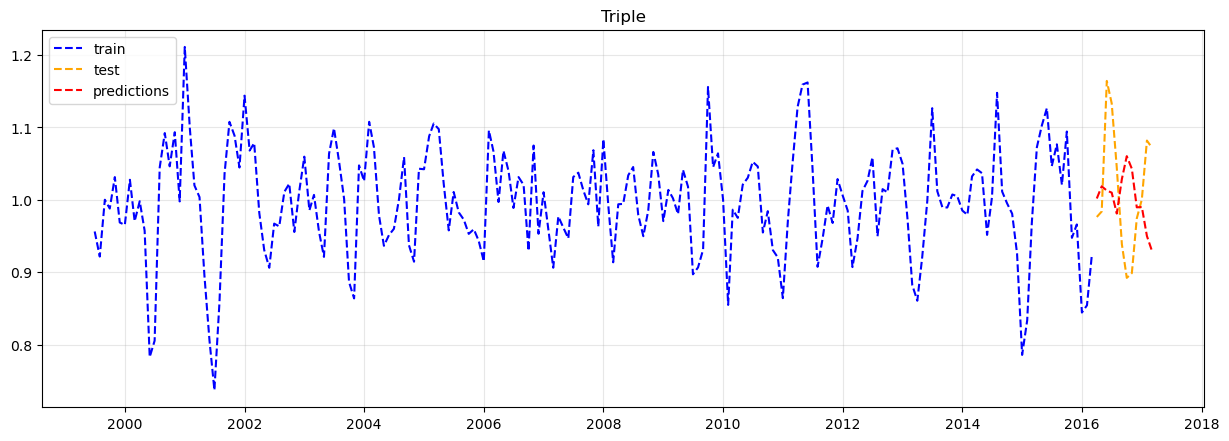

In [100]:
plot_smooth(test_mul, train_mul, triple_preds_mul, "Triple")

 # Smoothing model(Ln add decom)

In [103]:
train_add_ln = ln_residual_a[:-12]
test_add_ln = ln_residual_a[-12:]

In [107]:
simple_avg_preds_add_ln = simple_avarage(ln_residual_a, train_add_ln, test_add_ln)

Predictions:  [-0.00094154 -0.00094154 -0.00094154 -0.00094154 -0.00094154 -0.00094154
 -0.00094154 -0.00094154 -0.00094154 -0.00094154 -0.00094154 -0.00094154]
MSE:  0.08609196085332921


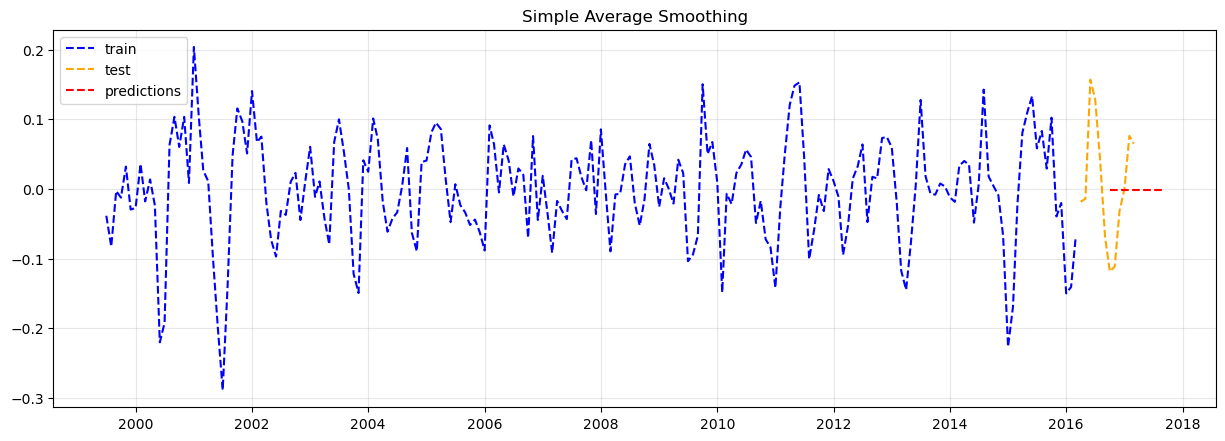

In [108]:
plot_smooth(test_add_ln, train_add_ln, simple_avg_preds_add_ln, "Simple Average Smoothing")

In [109]:
single_preds_add_ln = single(train_add_ln, test_add_ln)

Predictions:  2016-04-01   -0.078702
2016-05-01   -0.078702
2016-06-01   -0.078702
2016-07-01   -0.078702
2016-08-01   -0.078702
2016-09-01   -0.078702
2016-10-01   -0.078702
2016-11-01   -0.078702
2016-12-01   -0.078702
2017-01-01   -0.078702
2017-02-01   -0.078702
2017-03-01   -0.078702
Freq: MS, dtype: float64
MSE:  0.1770859959749729


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


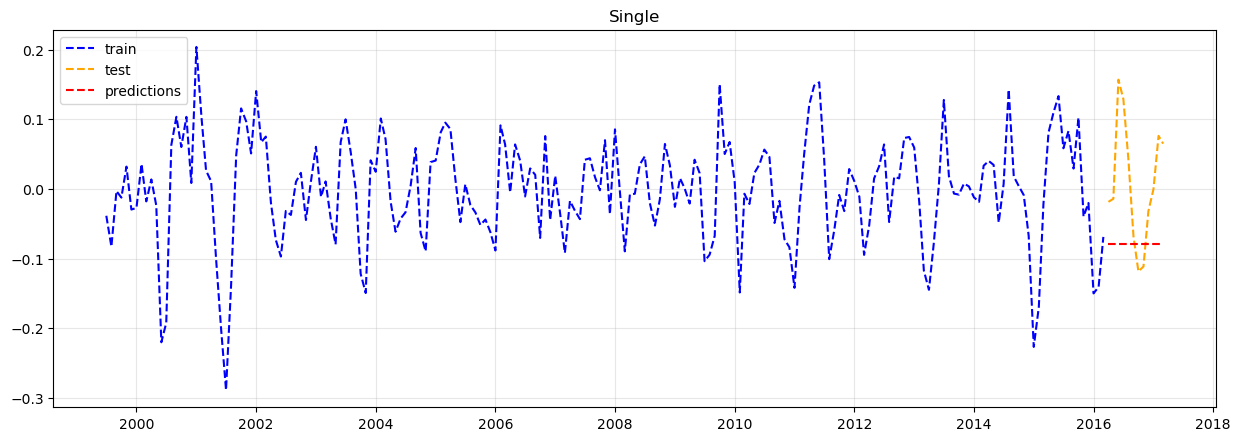

In [110]:
plot_smooth(test_add_ln, train_add_ln, single_preds_add_ln, "Single")

In [111]:
double_preds_add_ln = double(train_add_ln, test_add_ln)

Predictions:  2016-04-01   -0.078955
2016-05-01   -0.079145
2016-06-01   -0.079336
2016-07-01   -0.079526
2016-08-01   -0.079716
2016-09-01   -0.079907
2016-10-01   -0.080097
2016-11-01   -0.080287
2016-12-01   -0.080478
2017-01-01   -0.080668
2017-02-01   -0.080858
2017-03-01   -0.081048
Freq: MS, dtype: float64
MSE:  0.17971454992268088


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


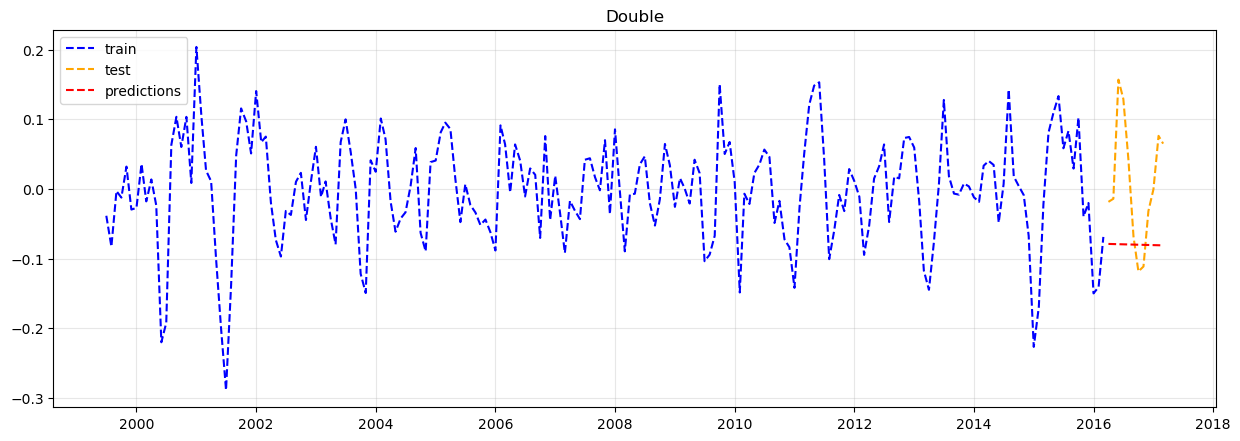

In [112]:
plot_smooth(test_add_ln, train_add_ln, double_preds_add_ln, "Double")

In [116]:
triple_preds_add_ln = triple(train_add_ln, test_add_ln)

c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Predictions:  2016-04-01    0.006304
2016-05-01    0.023269
2016-06-01    0.014782
2016-07-01    0.011319
2016-08-01   -0.015349
2016-09-01    0.032257
2016-10-01    0.061906
2016-11-01    0.047119
2016-12-01   -0.003769
2017-01-01   -0.003452
2017-02-01   -0.046247
2017-03-01   -0.068780
Freq: MS, dtype: float64
MSE:  0.1409916611729598


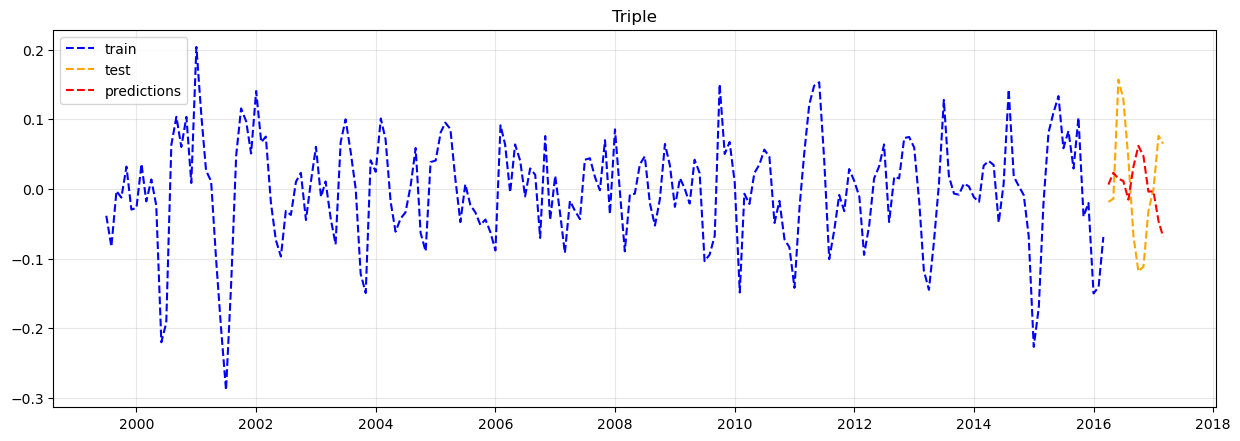

In [117]:
plot_smooth(test_add_ln, train_add_ln, triple_preds_add_ln, "Triple")

 # Smoothing model(Ln mul decom)

In [118]:
train_mul_ln = ln_residual_m[:-12]
test_mul_ln = ln_residual_m[-12:]

In [119]:
simple_avg_preds_mul_ln = simple_avarage(ln_residual_m, train_mul_ln, test_mul_ln)

Predictions:  [0.99983558 0.99983558 0.99983558 0.99983558 0.99983558 0.99983558
 0.99983558 0.99983558 0.99983558 0.99983558 0.99983558 0.99983558]
MSE:  0.004171513193800004


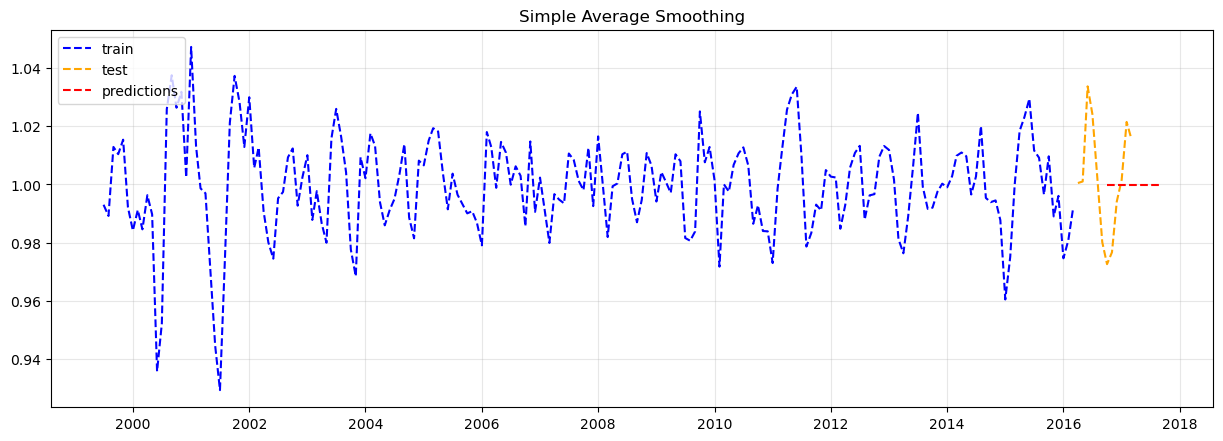

In [120]:
plot_smooth(test_mul_ln, train_mul_ln, simple_avg_preds_mul_ln, "Simple Average Smoothing")

In [121]:
single_preds_mul_ln = single(train_mul_ln, test_mul_ln)

Predictions:  2016-04-01    0.990335
2016-05-01    0.990335
2016-06-01    0.990335
2016-07-01    0.990335
2016-08-01    0.990335
2016-09-01    0.990335
2016-10-01    0.990335
2016-11-01    0.990335
2016-12-01    0.990335
2017-01-01    0.990335
2017-02-01    0.990335
2017-03-01    0.990335
Freq: MS, dtype: float64
MSE:  0.005755372601188318


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


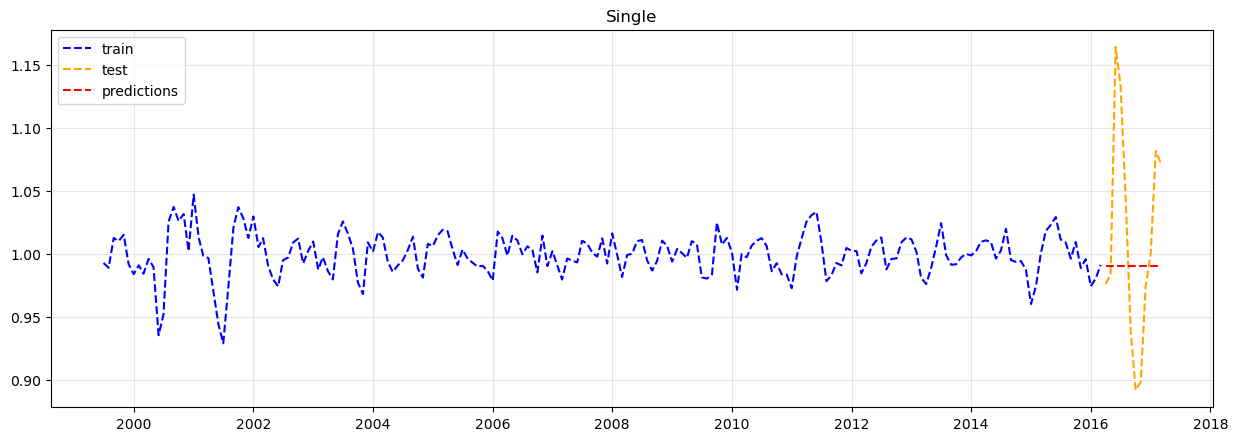

In [122]:
plot_smooth(test_mul, train_mul_ln, single_preds_mul_ln, "Single")

In [123]:
double_preds_mul_ln = double(train_mul_ln, test_mul_ln)

Predictions:  2016-04-01    0.990397
2016-05-01    0.990382
2016-06-01    0.990366
2016-07-01    0.990351
2016-08-01    0.990335
2016-09-01    0.990320
2016-10-01    0.990305
2016-11-01    0.990289
2016-12-01    0.990274
2017-01-01    0.990258
2017-02-01    0.990243
2017-03-01    0.990227
Freq: MS, dtype: float64
MSE:  0.005760299861857349


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


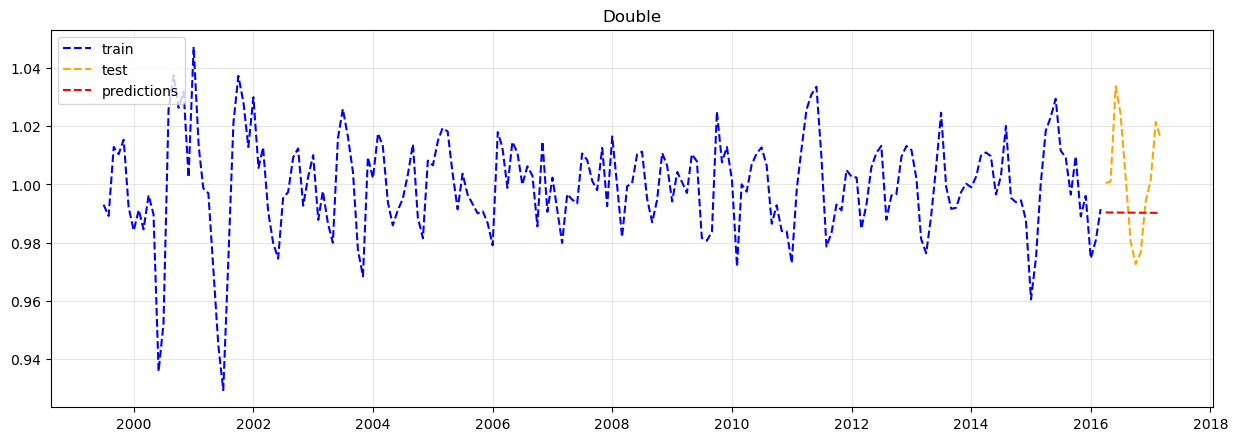

In [124]:
plot_smooth(test_mul_ln, train_mul_ln, double_preds_mul_ln, "Double")

In [125]:
triple_preds_mul_ln = triple(train_mul_ln, test_mul_ln)

c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Predictions:  2016-04-01    1.003040
2016-05-01    1.006857
2016-06-01    1.005480
2016-07-01    1.005555
2016-08-01    0.999755
2016-09-01    1.006560
2016-10-01    1.009666
2016-11-01    1.005557
2016-12-01    0.996291
2017-01-01    0.997263
2017-02-01    0.990195
2017-03-01    0.987891
Freq: MS, dtype: float64
MSE:  0.005880103719729767


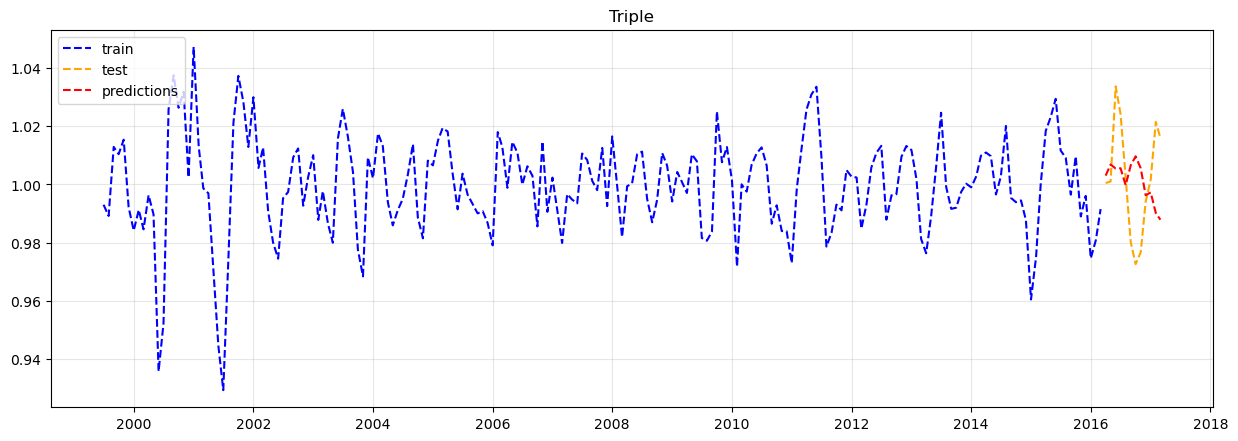

In [126]:
plot_smooth(test_mul_ln, train_mul_ln, triple_preds_mul_ln, "Triple")

 # Smoothing model(Raw add decom)

In [128]:
train_diff = TS_diff[:-12]
test_diff = TS_diff[-12:]

In [129]:
simple_avg_preds_diff = simple_avarage(TS_diff, train_diff, test_diff)

Predictions:  [1.596125 1.596125 1.596125 1.596125 1.596125 1.596125 1.596125 1.596125
 1.596125 1.596125 1.596125 1.596125]
MSE:  6728.767212937491


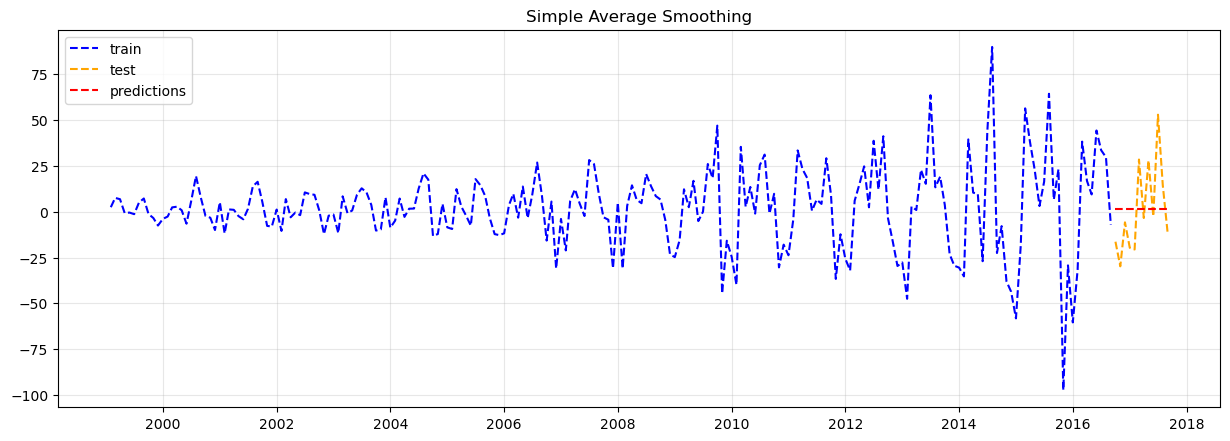

In [130]:
plot_smooth(test_diff, train_diff, simple_avg_preds_diff, "Simple Average Smoothing")

In [131]:
single_preds_diff = single(train_diff, test_diff)

Predictions:  2016-10-01    1.575903
2016-11-01    1.575903
2016-12-01    1.575903
2017-01-01    1.575903
2017-02-01    1.575903
2017-03-01    1.575903
2017-04-01    1.575903
2017-05-01    1.575903
2017-06-01    1.575903
2017-07-01    1.575903
2017-08-01    1.575903
2017-09-01    1.575903
Freq: MS, dtype: float64
MSE:  6728.553373888967


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


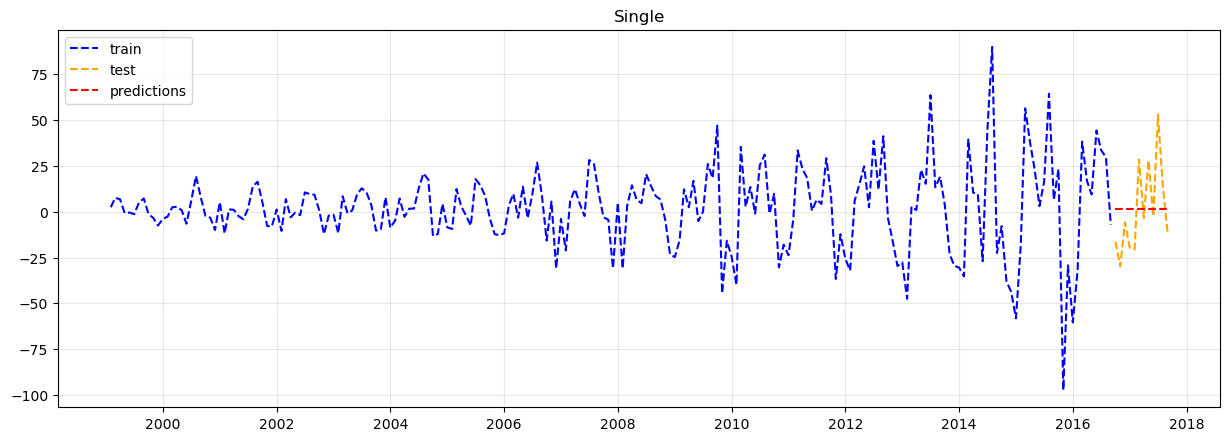

In [133]:
plot_smooth(test_diff, train_diff, single_preds_diff, "Single")

In [134]:
double_preds_diff = double(train_diff, test_diff)

Predictions:  2016-10-01    12.583939
2016-11-01    12.617094
2016-12-01    12.650249
2017-01-01    12.683404
2017-02-01    12.716559
2017-03-01    12.749713
2017-04-01    12.782868
2017-05-01    12.816023
2017-06-01    12.849178
2017-07-01    12.882333
2017-08-01    12.915488
2017-09-01    12.948643
Freq: MS, dtype: float64
MSE:  8311.86442201607


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


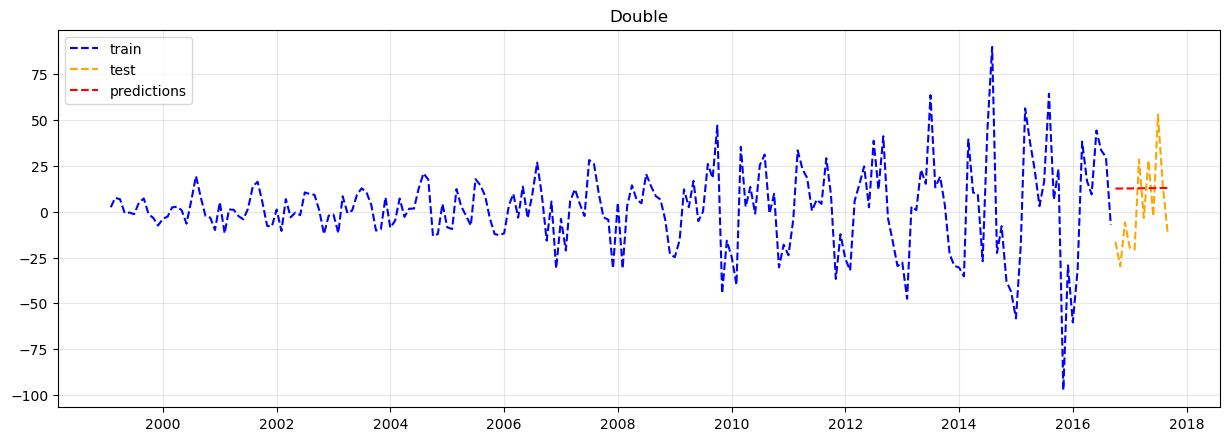

In [135]:
plot_smooth(test_diff, train_diff, double_preds_diff, "Double")

In [136]:
triple_preds_diff = triple(train_diff, test_diff)

c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Predictions:  2016-10-01    34.763718
2016-11-01    10.226050
2016-12-01   -44.716597
2017-01-01   -19.468247
2017-02-01   -41.302743
2017-03-01   -33.788687
2017-04-01     7.212970
2017-05-01    15.399604
2017-06-01    14.530425
2017-07-01    26.951961
2017-08-01    18.103904
2017-09-01    17.113142
Freq: MS, dtype: float64
MSE:  12095.061610878109


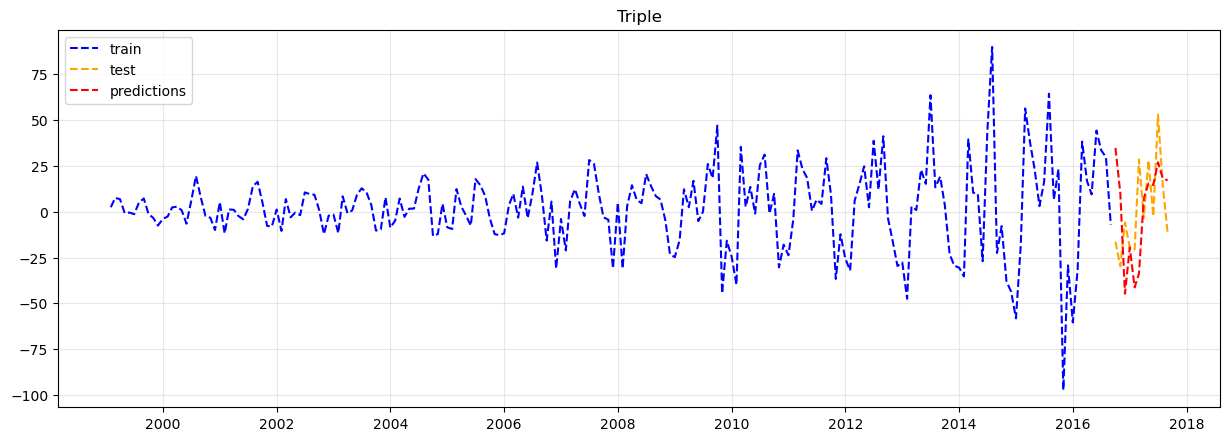

In [137]:
plot_smooth(test_diff, train_diff, triple_preds_diff, "Triple")

 # Smoothing model(Ln add diff)

In [138]:
train_diff_ln = TS_diff_ln[:-12]
test_diff_ln = TS_diff_ln[-12:]

In [139]:
simple_avg_preds_diff_ln = simple_avarage(TS_diff_ln, train_diff_ln, test_diff_ln)

Predictions:  [0.01246201 0.01246201 0.01246201 0.01246201 0.01246201 0.01246201
 0.01246201 0.01246201 0.01246201 0.01246201 0.01246201 0.01246201]
MSE:  0.06340255010042595


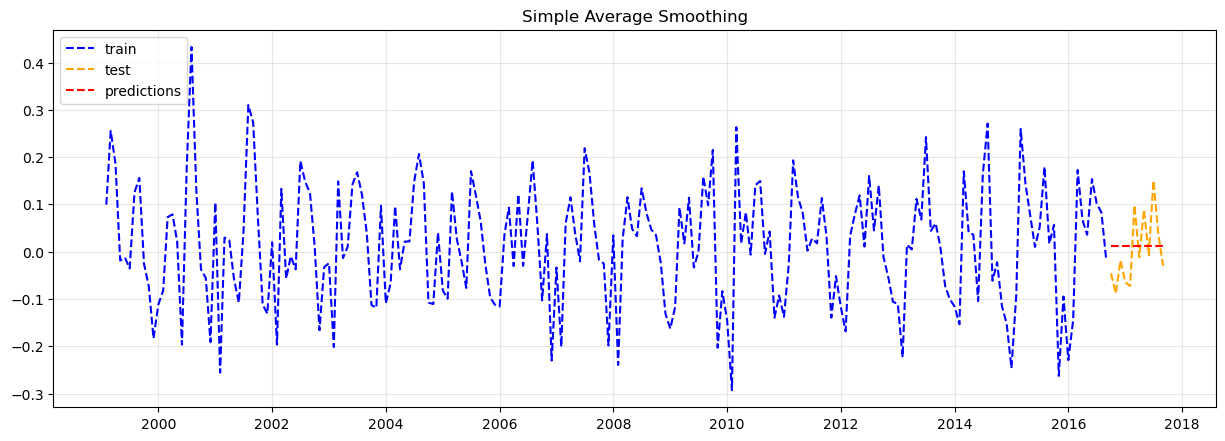

In [140]:
plot_smooth(test_diff_ln, train_diff_ln, simple_avg_preds_diff_ln, "Simple Average Smoothing")

In [141]:
single_preds_diff_ln = single(train_diff_ln, test_diff_ln)

Predictions:  2016-10-01    0.012994
2016-11-01    0.012994
2016-12-01    0.012994
2017-01-01    0.012994
2017-02-01    0.012994
2017-03-01    0.012994
2017-04-01    0.012994
2017-05-01    0.012994
2017-06-01    0.012994
2017-07-01    0.012994
2017-08-01    0.012994
2017-09-01    0.012994
Freq: MS, dtype: float64
MSE:  0.06352596121438302


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


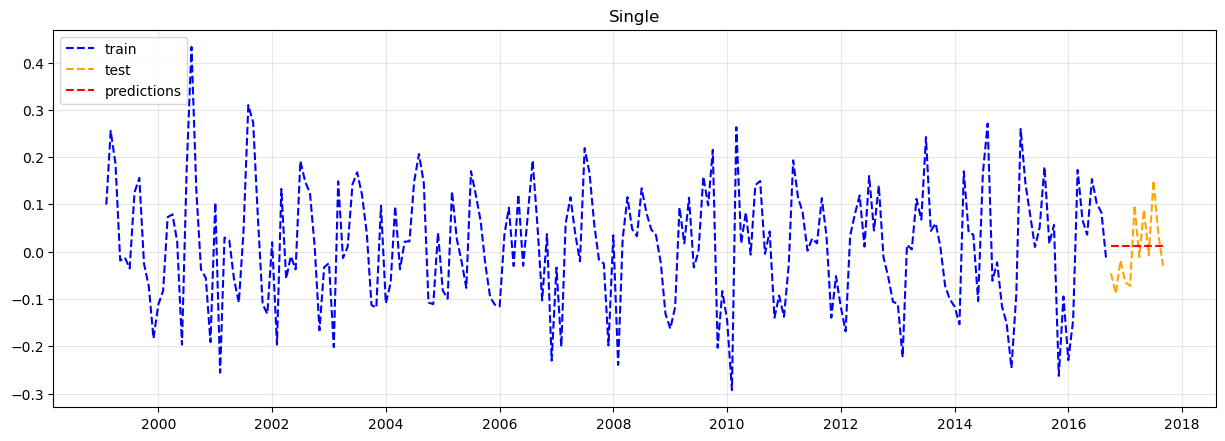

In [142]:
plot_smooth(test_diff_ln, train_diff_ln, single_preds_diff_ln, "Single")

In [143]:
double_preds_diff_ln = double(train_diff_ln,  test_diff_ln)

Predictions:  2016-10-01    0.004152
2016-11-01    0.004069
2016-12-01    0.003986
2017-01-01    0.003903
2017-02-01    0.003820
2017-03-01    0.003737
2017-04-01    0.003654
2017-05-01    0.003571
2017-06-01    0.003488
2017-07-01    0.003405
2017-08-01    0.003321
2017-09-01    0.003238
Freq: MS, dtype: float64
MSE:  0.06260945994138052


c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


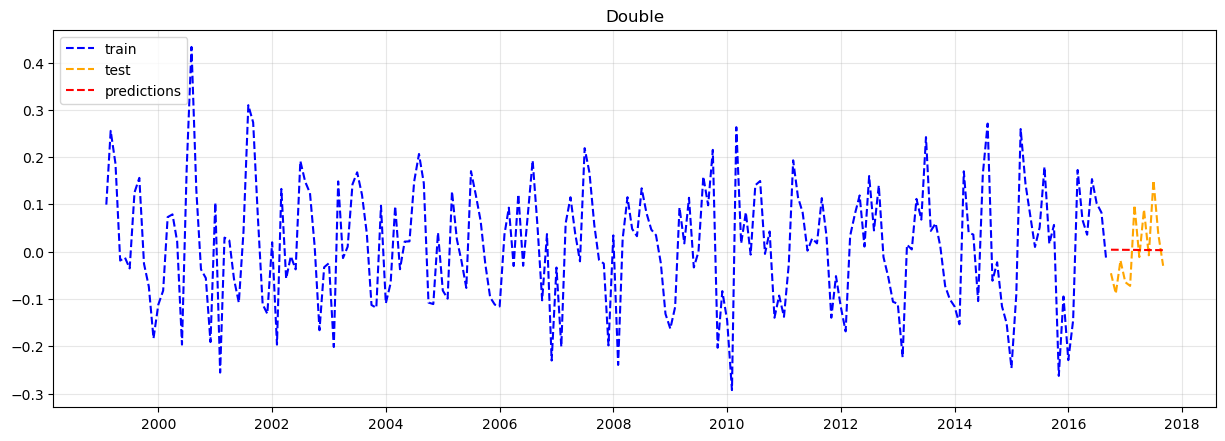

In [145]:
plot_smooth(test_diff_ln, train_diff_ln, double_preds_diff_ln, "Double")

In [146]:
triple_preds_diff_ln = triple(train_diff_ln, test_diff_ln)

c:\users\home\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Predictions:  2016-10-01    0.036633
2016-11-01    0.030096
2016-12-01    0.013349
2017-01-01   -0.002899
2017-02-01   -0.029472
2017-03-01   -0.036384
2017-04-01   -0.011708
2017-05-01   -0.003779
2017-06-01   -0.002794
2017-07-01    0.020915
2017-08-01    0.016602
2017-09-01    0.010376
Freq: MS, dtype: float64
MSE:  0.07320904698179569


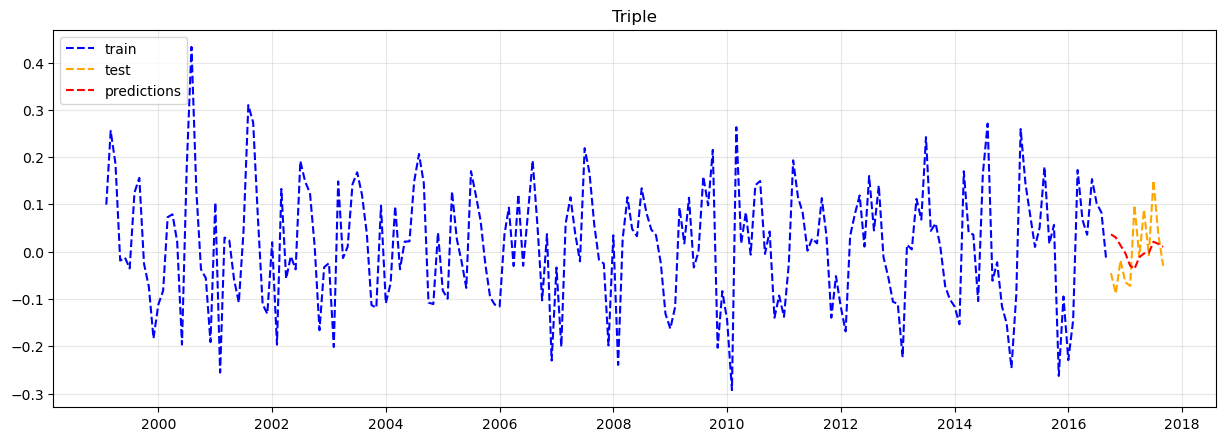

In [147]:
plot_smooth(test_diff_ln, train_diff_ln, triple_preds_diff_ln, "Triple")

In [ ]:
 # Smoothing model(Raw add decom)

train_add = residual_a[:-12]
test_add = residual_a[-12:]

simple_avg_preds_add = simple_avarage(residual_a, train_add, test_add)

plot_smooth(test_add, train_add, simple_avg_preds_add, "Simple Average Smoothing")

single_preds_add = single(train_add, test_add)

plot_smooth(test_add, train_add, single_preds_add, "Single")

double_preds_add = double(train_add, test_add)

plot_smooth(test_add, train_add, double_preds_add, "Double")

triple_preds_add = triple(train_add, test_add)

plot_smooth(test_add, train_add, triple_preds_add, "Triple")